In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

import os
from numpy import genfromtxt
from keras import backend as K
import numpy as np
from keras.layers import Input, Lambda, Conv2D
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Lambda, Flatten, Dense


In [3]:
import os
from collections import defaultdict
import cv2
import numpy as np
import tensorflow

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
# from keras.engine.topology import Layer
from tensorflow.keras import layers
from keras import backend as K
K.set_image_data_format('channels_first')
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
# from inception_block_model.py import imgRecoModel

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [4]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [5]:
altered_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered'
real_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Real'

dic_alt_easy = get_data_dic(altered_path + '-Easy')
dic_alt_hard = get_data_dic(altered_path + '-Hard')
dic_alt_med = get_data_dic(altered_path + '-Medium')
dic_real = get_data_dic(real_path, train=False)

In [6]:
def merge_data(dic1, dic2, dic3):

    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2

    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3

    return dic1

In [7]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [8]:

dict1 = {key: dic_data[key] for key in list(dic_data.keys())[:5000]}
dict2 = {key: dic_data[key] for key in list(dic_data.keys())[5000:]}

In [9]:
dic_data=dict1

In [10]:
test_dict=dict2

In [11]:
ids = list(test_dict.keys())
len(ids)

1000

In [12]:

def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [13]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [14]:
def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )


def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [15]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


1/1 [==============================] - 7s 7s/step


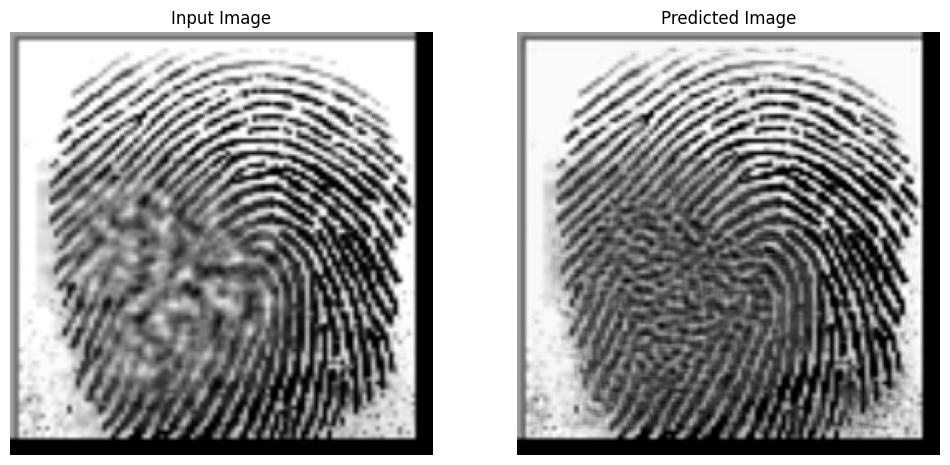

Predicted image saved at: /content/sample_data/predicted_image1.BMP


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
model = load_model('/content/drive/MyDrive/Model/SRCNN_soco_5K_img.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/100__M_Left_index_finger_Obl.BMP'  # Replace with the path to your input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (256, 256))
input_image = input_image.astype('float32') / 255.0

# Predict the high-resolution image
input_array = np.expand_dims(input_image, axis=0)
predicted_image = model.predict(input_array)[0]

# Display the input and predicted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Image')
plt.imshow(predicted_image)
plt.axis('off')

plt.show()

# Save the predicted image
output_image_path = '/content/sample_data/predicted_image1.BMP'  # Replace with the desired output path
cv2.imwrite(output_image_path, cv2.cvtColor((predicted_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print("Predicted image saved at:", output_image_path)

In [79]:
real_min_alt_dist_CR=[]
real_min_enhAlt_dist_CR=[]
enhReal_min_enhAlt_dist_CR=[]
real_min_alt_dist_Obl=[]
real_min_enhAlt_dist_Obl=[]
enhReal_min_enhAlt_dist_Obl=[]
real_min_alt_dist_Zcut=[]
real_min_enhAlt_dist_Zcut=[]
enhReal_min_enhAlt_dist_Zcut=[]

In [80]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import Image, display
from PIL import Image

real_min_alt_dist=[]
real_min_enhAlt_dist=[]
enhReal_min_enhAlt_dist=[]

# Load the saved model
model = load_model('/content/drive/MyDrive/Model/SRCNN_soco_5K_img.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

# Load another model (assuming you have defined 'p' elsewhere in your code)
p = load_model('/content/drive/MyDrive/Model/model_siamese_git_with_testSplit.h5')




def compute_distance(real_image_path, alt_image_path):
    anc_img_path = real_image_path
    pos_img_path = alt_image_path

    anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img_path), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img_path), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)

    print(pos_img_path)

    if pos_img_path.split('.')[0].endswith('CR'):
       flag = 'CR'
    elif pos_img_path.split('.')[0].endswith('Obl'):
      flag='Obl'
    elif pos_img_path.split('.')[0].endswith('Zcut'):
      flag='Zcut'

    print("flag",flag)

    #neg_img = np.clip(model.predict(np.expand_dims(img_to_array(cv2.imread(pos_img_path)), axis=0)), 0.0, 1.0)[0]

    input_image = cv2.imread(anc_img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (256, 256))
    input_image = input_image.astype('float32') / 255.0

# Convert the input image to a NumPy array
   # input_array = img_to_array(input_image)
    #print(input_array.shape)
# Predict the high-resolution image
    #input_array_transposed = np.transpose(input_array, (1, 2, 0))  # Transpose dimensions
    #print(input_array_transposed.shape)
    input_array=np.expand_dims(input_image, axis=0)
    anc_img1 = model.predict(input_array)[0]

   # Resize the image using the LANCZOS interpolation method
    #anc_img1 = Image.fromarray(np.uint8(input_image * 255))  # Convert NumPy array to Pillow Image
    #neg_img = input_image_pil.resize((desired_width, desired_height), Image.LANCZOS)


# Save the resized image (replace 'output_image_path' with the desired output path)
    output_image_path_anc = '/content/sample_data/predicted_image_anchor.BMP'
    # Ensure values are within the valid range [0, 1]
    anc_img1 = np.clip(anc_img1, 0.0, 1.0)

# Convert the image back to uint8 format (0-255)
    anc_img1 = (anc_img1 * 255).astype(np.uint8)

    cv2.imwrite(output_image_path_anc, anc_img1)
    ''' img = cv2.imread(pos_img_path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    arrayImg=img_to_array(img)
    print(arrayImg)

    neg_img = np.clip(model.predict(arrayImg.reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    print(neg_img.shape)

    plt.imshow(neg_img)'''

    input_image = cv2.imread(pos_img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (256, 256))
    input_image = input_image.astype('float32') / 255.0

# Convert the input image to a NumPy array
    #input_array = img_to_array(input_image)

# Predict the high-resolution image
    #input_array_transposed = np.transpose(input_array, (1, 2, 0))  # Transpose dimensions

    input_array=np.expand_dims(input_image, axis=0)
    neg_img = model.predict(input_array)[0]
   # Resize the image using the LANCZOS interpolation method
    #neg_img = Image.fromarray(np.uint8(input_image * 255))  # Convert NumPy array to Pillow Image
    #neg_img = input_image_pil.resize((desired_width, desired_height), Image.LANCZOS)


# Save the resized image (replace 'output_image_path' with the desired output path)
    output_image_path_neg = '/content/sample_data/predicted_image.BMP'
    neg_img = np.clip(neg_img, 0.0, 1.0)

# Convert the image back to uint8 format (0-255)
    neg_img = (neg_img * 255).astype(np.uint8)
    cv2.imwrite(output_image_path_neg, neg_img)
    # Replace 'image_data' with your image data as a NumPy array
    #image_data = cv2.imread('image.jpg')


   # Convert 'neg_img' to a Pillow Image object
     # Convert 'neg_img' to a NumPy array
    anc_img1 = np.around(np.transpose(cv2.resize(cv2.imread('/content/sample_data/predicted_image_anchor.BMP'), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    neg_img = np.around(np.transpose(cv2.resize(cv2.imread('/content/sample_data/predicted_image.BMP'), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    pos_enc = p.predict_on_batch(np.expand_dims(pos_img, 0))
    anc_enc = p.predict_on_batch(np.expand_dims(anc_img, 0))
    neg_enc = p.predict_on_batch(np.expand_dims(neg_img, 0))
    anc_enc1 = p.predict_on_batch(np.expand_dims(anc_img1, 0))



    print('Distance between real - altered: ', np.linalg.norm(anc_enc - pos_enc))
    real_min_alt_dist.append(np.linalg.norm(anc_enc - pos_enc))
    print('Distance between real - enhanced altered: ', np.linalg.norm(anc_enc - neg_enc))
    real_min_enhAlt_dist.append(np.linalg.norm(anc_enc - neg_enc))
    print('Distance between enhanced real - enhanced altered: ', np.linalg.norm(anc_enc1 - neg_enc))
    enhReal_min_enhAlt_dist.append(np.linalg.norm(anc_enc1 - neg_enc))

    if flag == 'CR':
      real_min_alt_dist_CR.append(np.linalg.norm(anc_enc - pos_enc))
      real_min_enhAlt_dist_CR.append(np.linalg.norm(anc_enc - neg_enc))
      enhReal_min_enhAlt_dist_CR.append(np.linalg.norm(anc_enc1 - neg_enc))
    elif flag == 'Obl':
      real_min_alt_dist_Obl.append(np.linalg.norm(anc_enc - pos_enc))
      real_min_enhAlt_dist_Obl.append(np.linalg.norm(anc_enc - neg_enc))
      enhReal_min_enhAlt_dist_Obl.append(np.linalg.norm(anc_enc1 - neg_enc))
    elif flag=='Zcut':
      real_min_alt_dist_Zcut.append(np.linalg.norm(anc_enc - pos_enc))
      real_min_enhAlt_dist_Zcut.append(np.linalg.norm(anc_enc - neg_enc))
      enhReal_min_enhAlt_dist_Zcut.append(np.linalg.norm(anc_enc1 - neg_enc))
    #print(anc_img.shape)
    #print(pos_img.shape)
    #print(neg_img.shape)

'''    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))
    ax[0].title.set_text('Real Image')
    ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))
    ax[1].title.set_text('Altered Image')
    ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))
    ax[2].title.set_text('Enhanced Altered Image')
    #ax[3].imshow(np.transpose(anc_enc1, (1, 2, 0)))
    #ax[3].title.set_text('Enhanced Real Image')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()'''

"    fig, ax = plt.subplots(1, 3, figsize=(10, 4))\n    ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))\n    ax[0].title.set_text('Real Image')\n    ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))\n    ax[1].title.set_text('Altered Image')\n    ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))\n    ax[2].title.set_text('Enhanced Altered Image')\n    #ax[3].imshow(np.transpose(anc_enc1, (1, 2, 0)))\n    #ax[3].title.set_text('Enhanced Real Image')\n    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])\n    plt.show()"

In [69]:
#code for matching pairs

from tqdm import tqdm

prefix_to_extract = '/content/drive/MyDrive/SOCOFing/SOCOFing'

# Check if the input string contains the prefix to extract
ids = list(test_dict.keys())

# Create a tqdm instance to track progress
for id in tqdm(ids[:100]):
    input_stringList = test_dict[id]
    for input_string in input_stringList:
        if prefix_to_extract in input_string:
            # Extract the prefix part
            extracted_prefix = input_string.split(prefix_to_extract)[0] + prefix_to_extract

            # Extract the image name
            image_name = input_string.split(prefix_to_extract)[1].split('/')[-1]
            #print(image_name)
            # Remove undesired parts (e.g., "_CR.BMP")
            suffix = "_" + image_name.split('_')[-1]
            #print(suffix)
            if image_name.endswith(suffix):
                result_string = image_name.rstrip(suffix)
                result_string = result_string + '.BMP'
                #print(result_string)

            # Append the suffix to the prefix
            real_image_path = extracted_prefix + '/Real/' + result_string
            alt_image_path = input_string
            compute_distance(real_image_path, alt_image_path)


  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/216__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.011028714
Distance between real - enhanced altered:  0.26297614
Distance between enhanced real - enhanced altered:  0.005661172
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/216__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0050517977
Distance between real - enhanced altered:  0.26122466
Distance between enhanced real - enhanced altered:  0.004033005
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/216__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00046724136
Distance between real - enhanced altered:  0.2619648
Distance between enhanced real - enhanced altered:  0.00037182047
/content/drive/MyDrive/SOCOFin

  1%|          | 1/100 [00:02<03:39,  2.21s/it]

Distance between real - altered:  0.009100908
Distance between real - enhanced altered:  0.26299912
Distance between enhanced real - enhanced altered:  0.0062563154
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0068049943
Distance between real - enhanced altered:  0.44392502
Distance between enhanced real - enhanced altered:  0.0054931566
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0835119
Distance between real - enhanced altered:  0.44680056
Distance between enhanced real - enhanced altered:  0.07217544
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

  2%|▏         | 2/100 [00:03<02:56,  1.80s/it]

Distance between real - altered:  0.02249892
Distance between real - enhanced altered:  0.43622974
Distance between enhanced real - enhanced altered:  0.022614835
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0011677342
Distance between real - enhanced altered:  0.10989544
Distance between enhanced real - enhanced altered:  0.0011072821
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00040250484
Distance between real - enhanced altered:  0.11036236
Distance between enhanced real - enhanced altered:  0.0004319761
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered: 

  3%|▎         | 3/100 [00:04<02:26,  1.51s/it]

Distance between real - altered:  0.001265139
Distance between real - enhanced altered:  0.10958552
Distance between enhanced real - enhanced altered:  0.0017579548
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.009945537
Distance between real - enhanced altered:  0.05247311
Distance between enhanced real - enhanced altered:  0.012456496
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0011835459
Distance between real - enhanced altered:  0.0627486
Distance between enhanced real - enhanced altered:  0.0010435047
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/217__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

  4%|▍         | 4/100 [00:06<02:20,  1.46s/it]

Distance between real - altered:  0.20851801
Distance between real - enhanced altered:  0.26272643
Distance between enhanced real - enhanced altered:  0.25739214
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0008624288
Distance between real - enhanced altered:  0.10595387
Distance between enhanced real - enhanced altered:  0.0005578381
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.028048001
Distance between real - enhanced altered:  0.10944658
Distance between enhanced real - enhanced altered:  0.009900584
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0

  5%|▌         | 5/100 [00:07<02:14,  1.41s/it]

Distance between real - altered:  0.00092603924
Distance between real - enhanced altered:  0.10582923
Distance between enhanced real - enhanced altered:  0.0012460878
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0028708633
Distance between real - enhanced altered:  0.3650652
Distance between enhanced real - enhanced altered:  0.0015411217
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00019538903
Distance between real - enhanced altered:  0.37268972
Distance between enhanced real - enhanced altered:  0.009273998
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

  6%|▌         | 6/100 [00:08<01:58,  1.26s/it]

Distance between real - altered:  0.005427918
Distance between real - enhanced altered:  0.3675611
Distance between enhanced real - enhanced altered:  0.0037800616
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0002298474
Distance between real - enhanced altered:  0.24173982
Distance between enhanced real - enhanced altered:  0.00025396002
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.007619324
Distance between real - enhanced altered:  0.2439001
Distance between enhanced real - enhanced altered:  0.00306792
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.001

  7%|▋         | 7/100 [00:09<01:53,  1.22s/it]

Distance between real - altered:  0.04784543
Distance between real - enhanced altered:  0.25811937
Distance between enhanced real - enhanced altered:  0.043220308
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.033194885
Distance between real - enhanced altered:  0.1341047
Distance between enhanced real - enhanced altered:  0.048067722
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0030866135
Distance between real - enhanced altered:  0.1623504
Distance between enhanced real - enhanced altered:  0.0049403897
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

  8%|▊         | 8/100 [00:11<01:59,  1.30s/it]

Distance between real - altered:  0.01756042
Distance between real - enhanced altered:  0.17510515
Distance between enhanced real - enhanced altered:  0.014120433
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0052785315
Distance between real - enhanced altered:  0.11677115
Distance between enhanced real - enhanced altered:  0.0022931418
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00023624588
Distance between real - enhanced altered:  0.11840021
Distance between enhanced real - enhanced altered:  0.00019027875
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

  9%|▉         | 9/100 [00:12<01:58,  1.30s/it]

Distance between real - altered:  0.058870945
Distance between real - enhanced altered:  0.114932984
Distance between enhanced real - enhanced altered:  0.012216512
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.042582408
Distance between real - enhanced altered:  1.0095481
Distance between enhanced real - enhanced altered:  0.009692013
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.001384845
Distance between real - enhanced altered:  1.0113798
Distance between enhanced real - enhanced altered:  0.0015902256
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0296906

 10%|█         | 10/100 [00:13<01:52,  1.25s/it]

Distance between real - altered:  0.15399738
Distance between real - enhanced altered:  1.0102799
Distance between enhanced real - enhanced altered:  0.034264028
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.024751386
Distance between real - enhanced altered:  0.064399734
Distance between enhanced real - enhanced altered:  0.010277928
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.022595474
Distance between real - enhanced altered:  0.06269482
Distance between enhanced real - enhanced altered:  0.007354981
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00

 11%|█         | 11/100 [00:14<01:52,  1.26s/it]

Distance between real - altered:  0.0013435164
Distance between real - enhanced altered:  0.061797224
Distance between enhanced real - enhanced altered:  0.0007615173
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0007661556
Distance between real - enhanced altered:  0.19771715
Distance between enhanced real - enhanced altered:  0.0008980355
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.02243798
Distance between real - enhanced altered:  0.189619
Distance between enhanced real - enhanced altered:  0.009331829
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

 12%|█▏        | 12/100 [00:16<01:48,  1.23s/it]

Distance between real - altered:  0.001794634
Distance between real - enhanced altered:  0.19692229
Distance between enhanced real - enhanced altered:  0.0023447585
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0003526304
Distance between real - enhanced altered:  0.39790076
Distance between enhanced real - enhanced altered:  0.00045794036
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.015854996
Distance between real - enhanced altered:  0.39598435
Distance between enhanced real - enhanced altered:  0.0024058202
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - alter

 13%|█▎        | 13/100 [00:17<01:45,  1.22s/it]

Distance between real - altered:  0.04900283
Distance between real - enhanced altered:  0.39892292
Distance between enhanced real - enhanced altered:  0.019838816
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.017247852
Distance between real - enhanced altered:  0.20080546
Distance between enhanced real - enhanced altered:  0.01159856
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0036455404
Distance between real - enhanced altered:  0.20689586
Distance between enhanced real - enhanced altered:  0.003527103
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.04

 14%|█▍        | 14/100 [00:18<01:53,  1.32s/it]

Distance between real - altered:  0.063625045
Distance between real - enhanced altered:  0.24373505
Distance between enhanced real - enhanced altered:  0.06129008
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002964114
Distance between real - enhanced altered:  0.21712884
Distance between enhanced real - enhanced altered:  0.0017743896
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00017382992
Distance between real - enhanced altered:  0.21818121
Distance between enhanced real - enhanced altered:  0.0003711584
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered

 15%|█▌        | 15/100 [00:20<01:58,  1.39s/it]

Distance between real - altered:  0.0068669785
Distance between real - enhanced altered:  0.21843615
Distance between enhanced real - enhanced altered:  0.0036113916
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0019653123
Distance between real - enhanced altered:  0.07632731
Distance between enhanced real - enhanced altered:  0.0012595785
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0052572023
Distance between real - enhanced altered:  0.08891895
Distance between enhanced real - enhanced altered:  0.016131254
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:

 16%|█▌        | 16/100 [00:22<02:05,  1.50s/it]

Distance between real - altered:  0.0014134366
Distance between real - enhanced altered:  0.07711749
Distance between enhanced real - enhanced altered:  0.0017815512
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.0008458107
Distance between real - enhanced altered:  0.2666415
Distance between enhanced real - enhanced altered:  0.0004282642
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 26ms/step
Distance between real - altered:  0.024206659
Distance between real - enhanced altered:  0.26951116
Distance between enhanced real - enhanced altered:  0.010608943
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 26ms/step
Distance between real - altered:  0.0

 17%|█▋        | 17/100 [00:23<01:59,  1.44s/it]

Distance between real - altered:  0.014651682
Distance between real - enhanced altered:  0.26222846
Distance between enhanced real - enhanced altered:  0.005038435
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.0090066325
Distance between real - enhanced altered:  0.75297576
Distance between enhanced real - enhanced altered:  0.007981085
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.0021573794
Distance between real - enhanced altered:  0.7548339
Distance between enhanced real - enhanced altered:  0.0009281031
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.05

 18%|█▊        | 18/100 [00:24<01:44,  1.27s/it]

Distance between real - altered:  0.058802534
Distance between real - enhanced altered:  0.6728181
Distance between enhanced real - enhanced altered:  0.113572516
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.035569765
Distance between real - enhanced altered:  0.2414341
Distance between enhanced real - enhanced altered:  0.022527944
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0050983583
Distance between real - enhanced altered:  0.24687622
Distance between enhanced real - enhanced altered:  0.004349784
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/219__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00

 19%|█▉        | 19/100 [00:25<01:32,  1.15s/it]

Distance between real - altered:  0.018157134
Distance between real - enhanced altered:  0.25120258
Distance between enhanced real - enhanced altered:  0.007604635
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.003513107
Distance between real - enhanced altered:  0.1701029
Distance between enhanced real - enhanced altered:  0.0026758998
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.009210153
Distance between real - enhanced altered:  0.17301154
Distance between enhanced real - enhanced altered:  0.0018194352
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.000

 20%|██        | 20/100 [00:26<01:32,  1.16s/it]

Distance between real - altered:  0.01362157
Distance between real - enhanced altered:  0.1797149
Distance between enhanced real - enhanced altered:  0.012049105
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0027017014
Distance between real - enhanced altered:  0.11169797
Distance between enhanced real - enhanced altered:  0.0028658572
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00070239144
Distance between real - enhanced altered:  0.11112692
Distance between enhanced real - enhanced altered:  0.0005447214
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  

 21%|██        | 21/100 [00:27<01:27,  1.11s/it]

Distance between real - altered:  0.0032647932
Distance between real - enhanced altered:  0.10736286
Distance between enhanced real - enhanced altered:  0.0040754382
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00793016
Distance between real - enhanced altered:  0.19131774
Distance between enhanced real - enhanced altered:  0.006612224
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0006241805
Distance between real - enhanced altered:  0.19664373
Distance between enhanced real - enhanced altered:  0.0007157715
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0448

 22%|██▏       | 22/100 [00:28<01:20,  1.04s/it]

Distance between real - altered:  0.004913759
Distance between real - enhanced altered:  0.1938339
Distance between enhanced real - enhanced altered:  0.0040846462
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.024766862
Distance between real - enhanced altered:  0.1274214
Distance between enhanced real - enhanced altered:  0.0065806047
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.01119865
Distance between real - enhanced altered:  0.12975602
Distance between enhanced real - enhanced altered:  0.0038700397
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0032

 23%|██▎       | 23/100 [00:29<01:33,  1.21s/it]

Distance between real - altered:  0.0034172141
Distance between real - enhanced altered:  0.13207366
Distance between enhanced real - enhanced altered:  0.0033696047
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00097322406
Distance between real - enhanced altered:  0.15865071
Distance between enhanced real - enhanced altered:  0.0012188824
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0017919304
Distance between real - enhanced altered:  0.15615758
Distance between enhanced real - enhanced altered:  0.0035464799
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altere

 24%|██▍       | 24/100 [00:30<01:28,  1.16s/it]

Distance between real - altered:  0.004862245
Distance between real - enhanced altered:  0.1580565
Distance between enhanced real - enhanced altered:  0.0065320823
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.006467244
Distance between real - enhanced altered:  0.15605164
Distance between enhanced real - enhanced altered:  0.0034993258
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.034152634
Distance between real - enhanced altered:  0.15751281
Distance between enhanced real - enhanced altered:  0.015626183
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.

 25%|██▌       | 25/100 [00:32<01:35,  1.27s/it]

Distance between real - altered:  0.012700874
Distance between real - enhanced altered:  0.15637168
Distance between enhanced real - enhanced altered:  0.00829012
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.017976576
Distance between real - enhanced altered:  0.17946655
Distance between enhanced real - enhanced altered:  0.015360687
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0014766185
Distance between real - enhanced altered:  0.17048407
Distance between enhanced real - enhanced altered:  0.0015222898
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.07828945


 26%|██▌       | 26/100 [00:33<01:34,  1.28s/it]

Distance between real - altered:  0.004854671
Distance between real - enhanced altered:  0.16569376
Distance between enhanced real - enhanced altered:  0.0066649066
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.001897515
Distance between real - enhanced altered:  0.14611544
Distance between enhanced real - enhanced altered:  0.0024809607
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0039973394
Distance between real - enhanced altered:  0.14621061
Distance between enhanced real - enhanced altered:  0.0022469845
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.000

 27%|██▋       | 27/100 [00:35<01:34,  1.30s/it]

Distance between real - altered:  0.0043064584
Distance between real - enhanced altered:  0.14528918
Distance between enhanced real - enhanced altered:  0.003260941
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00047393187
Distance between real - enhanced altered:  0.48898324
Distance between enhanced real - enhanced altered:  0.00065434136
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.009923808
Distance between real - enhanced altered:  0.48815107
Distance between enhanced real - enhanced altered:  0.0086568715
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  

 28%|██▊       | 28/100 [00:36<01:38,  1.37s/it]

Distance between real - altered:  0.02445689
Distance between real - enhanced altered:  0.49631804
Distance between enhanced real - enhanced altered:  0.010021374
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00040659826
Distance between real - enhanced altered:  0.48000836
Distance between enhanced real - enhanced altered:  0.00072443084
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0042667487
Distance between real - enhanced altered:  0.47913596
Distance between enhanced real - enhanced altered:  0.0028263077
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - alter

 29%|██▉       | 29/100 [00:38<01:40,  1.41s/it]

Distance between real - altered:  0.036578294
Distance between real - enhanced altered:  0.47625828
Distance between enhanced real - enhanced altered:  0.061427433
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00031816086
Distance between real - enhanced altered:  0.110287346
Distance between enhanced real - enhanced altered:  0.00021992189
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.014605363
Distance between real - enhanced altered:  0.107265
Distance between enhanced real - enhanced altered:  0.009320724
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  

 30%|███       | 30/100 [00:39<01:33,  1.34s/it]

Distance between real - altered:  0.0020162056
Distance between real - enhanced altered:  0.10939827
Distance between enhanced real - enhanced altered:  0.005369432
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00059881445
Distance between real - enhanced altered:  0.18514597
Distance between enhanced real - enhanced altered:  0.0005954735
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0075226384
Distance between real - enhanced altered:  0.18406422
Distance between enhanced real - enhanced altered:  0.0071732793
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  

 31%|███       | 31/100 [00:40<01:35,  1.38s/it]

Distance between real - altered:  0.009228895
Distance between real - enhanced altered:  0.18158811
Distance between enhanced real - enhanced altered:  0.0048681316
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00016837493
Distance between real - enhanced altered:  0.11438253
Distance between enhanced real - enhanced altered:  0.00011376426
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.005370667
Distance between real - enhanced altered:  0.11427568
Distance between enhanced real - enhanced altered:  0.0012316523
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  

 32%|███▏      | 32/100 [00:42<01:32,  1.36s/it]

Distance between real - altered:  0.0052464865
Distance between real - enhanced altered:  0.11242857
Distance between enhanced real - enhanced altered:  0.0025208793
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0018232231
Distance between real - enhanced altered:  0.20094143
Distance between enhanced real - enhanced altered:  0.0019394576
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.09467996
Distance between real - enhanced altered:  0.2871269
Distance between enhanced real - enhanced altered:  0.14701962
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.000

 33%|███▎      | 33/100 [00:43<01:34,  1.41s/it]

Distance between real - altered:  0.0031899896
Distance between real - enhanced altered:  0.19868128
Distance between enhanced real - enhanced altered:  0.004051323
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0028219097
Distance between real - enhanced altered:  0.08845509
Distance between enhanced real - enhanced altered:  0.0029925203
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0005255243
Distance between real - enhanced altered:  0.08878663
Distance between enhanced real - enhanced altered:  0.0005955715
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00

 34%|███▍      | 34/100 [00:45<01:35,  1.44s/it]

Distance between real - altered:  0.0040798807
Distance between real - enhanced altered:  0.09043535
Distance between enhanced real - enhanced altered:  0.006325762
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0062942347
Distance between real - enhanced altered:  0.42637378
Distance between enhanced real - enhanced altered:  0.006246086
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0008978715
Distance between real - enhanced altered:  0.42330188
Distance between enhanced real - enhanced altered:  0.0008055099
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.

 35%|███▌      | 35/100 [00:46<01:34,  1.45s/it]

Distance between real - altered:  0.0037777172
Distance between real - enhanced altered:  0.41708896
Distance between enhanced real - enhanced altered:  0.016280366
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.013625705
Distance between real - enhanced altered:  0.16467705
Distance between enhanced real - enhanced altered:  0.016160747
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0012439702
Distance between real - enhanced altered:  0.15958337
Distance between enhanced real - enhanced altered:  0.0012362659
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  

 36%|███▌      | 36/100 [00:47<01:30,  1.41s/it]

Distance between real - altered:  0.0024449227
Distance between real - enhanced altered:  0.160083
Distance between enhanced real - enhanced altered:  0.0018084717
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0047549405
Distance between real - enhanced altered:  0.30192044
Distance between enhanced real - enhanced altered:  0.0034245052
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.022074688
Distance between real - enhanced altered:  0.34322438
Distance between enhanced real - enhanced altered:  0.05121366
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.

 37%|███▋      | 37/100 [00:49<01:29,  1.43s/it]

Distance between real - altered:  0.20234512
Distance between real - enhanced altered:  0.2564981
Distance between enhanced real - enhanced altered:  0.15686646
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.026069952
Distance between real - enhanced altered:  0.09681056
Distance between enhanced real - enhanced altered:  0.01476409
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0041239513
Distance between real - enhanced altered:  0.103035554
Distance between enhanced real - enhanced altered:  0.0066939746
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

 38%|███▊      | 38/100 [00:50<01:30,  1.45s/it]

Distance between real - altered:  0.02638576
Distance between real - enhanced altered:  0.08917628
Distance between enhanced real - enhanced altered:  0.029319014
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0010382453
Distance between real - enhanced altered:  0.16108038
Distance between enhanced real - enhanced altered:  0.0011054781
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0028969583
Distance between real - enhanced altered:  0.16438131
Distance between enhanced real - enhanced altered:  0.0033639767
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  

 39%|███▉      | 39/100 [00:52<01:26,  1.43s/it]

Distance between real - altered:  0.0023028906
Distance between real - enhanced altered:  0.16128904
Distance between enhanced real - enhanced altered:  0.002262831
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.009110232
Distance between real - enhanced altered:  0.93683577
Distance between enhanced real - enhanced altered:  0.0025015115
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0013115309
Distance between real - enhanced altered:  0.93642646
Distance between enhanced real - enhanced altered:  0.0014400531
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered: 

 40%|████      | 40/100 [00:53<01:26,  1.45s/it]

Distance between real - altered:  0.00921647
Distance between real - enhanced altered:  0.93965316
Distance between enhanced real - enhanced altered:  0.008730606
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0049116835
Distance between real - enhanced altered:  0.28817415
Distance between enhanced real - enhanced altered:  0.0028818005
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0021382533
Distance between real - enhanced altered:  0.2892163
Distance between enhanced real - enhanced altered:  0.0007430513
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 41%|████      | 41/100 [00:55<01:27,  1.48s/it]

Distance between real - altered:  0.0049526035
Distance between real - enhanced altered:  0.28781047
Distance between enhanced real - enhanced altered:  0.0034817127
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.002422884
Distance between real - enhanced altered:  0.2939419
Distance between enhanced real - enhanced altered:  0.0016923185
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.07828058
Distance between real - enhanced altered:  0.37943906
Distance between enhanced real - enhanced altered:  0.14098972
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  

 42%|████▏     | 42/100 [00:56<01:27,  1.50s/it]

Distance between real - altered:  0.007364699
Distance between real - enhanced altered:  0.298285
Distance between enhanced real - enhanced altered:  0.006937955
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0064722067
Distance between real - enhanced altered:  0.2672922
Distance between enhanced real - enhanced altered:  0.010687928
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00027418646
Distance between real - enhanced altered:  0.2572846
Distance between enhanced real - enhanced altered:  0.00023399525
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.003204

 43%|████▎     | 43/100 [00:58<01:25,  1.49s/it]

Distance between real - altered:  0.0024263556
Distance between real - enhanced altered:  0.26010624
Distance between enhanced real - enhanced altered:  0.0035182883
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.016051363
Distance between real - enhanced altered:  0.20842546
Distance between enhanced real - enhanced altered:  0.01073468
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.02685849
Distance between real - enhanced altered:  0.21018119
Distance between enhanced real - enhanced altered:  0.017505469
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0005

 44%|████▍     | 44/100 [00:59<01:20,  1.44s/it]

Distance between real - altered:  0.0024925258
Distance between real - enhanced altered:  0.21407253
Distance between enhanced real - enhanced altered:  0.0018385096
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0058208713
Distance between real - enhanced altered:  0.20556127
Distance between enhanced real - enhanced altered:  0.013295014
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00013962264
Distance between real - enhanced altered:  0.19565886
Distance between enhanced real - enhanced altered:  0.000117454445
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0

 45%|████▌     | 45/100 [01:01<01:20,  1.46s/it]

Distance between real - altered:  0.006808839
Distance between real - enhanced altered:  0.1961246
Distance between enhanced real - enhanced altered:  0.010300529
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00019720467
Distance between real - enhanced altered:  0.3500828
Distance between enhanced real - enhanced altered:  0.0001709135
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.020317255
Distance between real - enhanced altered:  0.3410022
Distance between enhanced real - enhanced altered:  0.015100781
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0047

 46%|████▌     | 46/100 [01:02<01:19,  1.47s/it]

Distance between real - altered:  0.055619337
Distance between real - enhanced altered:  0.3010638
Distance between enhanced real - enhanced altered:  0.05655557
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.10551552
Distance between real - enhanced altered:  0.17858192
Distance between enhanced real - enhanced altered:  0.028270097
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.021751052
Distance between real - enhanced altered:  0.17769319
Distance between enhanced real - enhanced altered:  0.017005844
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0006

 47%|████▋     | 47/100 [01:04<01:17,  1.46s/it]

Distance between real - altered:  0.0049118046
Distance between real - enhanced altered:  0.18578885
Distance between enhanced real - enhanced altered:  0.007750261
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002681576
Distance between real - enhanced altered:  0.14677924
Distance between enhanced real - enhanced altered:  0.0019382706
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.008852088
Distance between real - enhanced altered:  0.14814742
Distance between enhanced real - enhanced altered:  0.0041802977
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  

 48%|████▊     | 48/100 [01:05<01:16,  1.47s/it]

Distance between real - altered:  0.071109824
Distance between real - enhanced altered:  0.22016552
Distance between enhanced real - enhanced altered:  0.10911706
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0047384812
Distance between real - enhanced altered:  0.32028913
Distance between enhanced real - enhanced altered:  0.005748028
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0015139829
Distance between real - enhanced altered:  0.32415497
Distance between enhanced real - enhanced altered:  0.0018000472
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.00

 49%|████▉     | 49/100 [01:07<01:16,  1.49s/it]

Distance between real - altered:  0.040842865
Distance between real - enhanced altered:  0.33133295
Distance between enhanced real - enhanced altered:  0.0681167
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0004122734
Distance between real - enhanced altered:  0.46576223
Distance between enhanced real - enhanced altered:  0.0007507452
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.002819744
Distance between real - enhanced altered:  0.4656799
Distance between enhanced real - enhanced altered:  0.0025085392
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0138

 50%|█████     | 50/100 [01:08<01:15,  1.52s/it]

Distance between real - altered:  0.02121019
Distance between real - enhanced altered:  0.48404178
Distance between enhanced real - enhanced altered:  0.03251685
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0013444513
Distance between real - enhanced altered:  0.08145179
Distance between enhanced real - enhanced altered:  0.0025539454
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0009057275
Distance between real - enhanced altered:  0.08146584
Distance between enhanced real - enhanced altered:  0.00068359403
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered

 51%|█████     | 51/100 [01:10<01:14,  1.53s/it]

Distance between real - altered:  0.0009107668
Distance between real - enhanced altered:  0.08085407
Distance between enhanced real - enhanced altered:  0.0011698238
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0005196378
Distance between real - enhanced altered:  0.383929
Distance between enhanced real - enhanced altered:  0.00079219195
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.017773965
Distance between real - enhanced altered:  0.37837166
Distance between enhanced real - enhanced altered:  0.014132669
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 52%|█████▏    | 52/100 [01:11<01:12,  1.52s/it]

Distance between real - altered:  0.013102243
Distance between real - enhanced altered:  0.37953317
Distance between enhanced real - enhanced altered:  0.011686898
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.30491966
Distance between real - enhanced altered:  0.32336828
Distance between enhanced real - enhanced altered:  0.16828994
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.11293831
Distance between real - enhanced altered:  0.24791887
Distance between enhanced real - enhanced altered:  0.10171828
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00209

 53%|█████▎    | 53/100 [01:13<01:11,  1.51s/it]

Distance between real - altered:  0.01672157
Distance between real - enhanced altered:  0.18977422
Distance between enhanced real - enhanced altered:  0.008556036
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0008792765
Distance between real - enhanced altered:  0.38022524
Distance between enhanced real - enhanced altered:  0.0010116217
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0047426857
Distance between real - enhanced altered:  0.378381
Distance between enhanced real - enhanced altered:  0.0049287574
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.089

 54%|█████▍    | 54/100 [01:14<01:08,  1.50s/it]

Distance between real - altered:  0.003405877
Distance between real - enhanced altered:  0.37867972
Distance between enhanced real - enhanced altered:  0.00386498
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.009181692
Distance between real - enhanced altered:  0.7415919
Distance between enhanced real - enhanced altered:  0.0062360535
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0013475103
Distance between real - enhanced altered:  0.7392296
Distance between enhanced real - enhanced altered:  0.0014818473
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0

 55%|█████▌    | 55/100 [01:16<01:07,  1.49s/it]

Distance between real - altered:  0.0060130083
Distance between real - enhanced altered:  0.7402841
Distance between enhanced real - enhanced altered:  0.0038222848
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002031396
Distance between real - enhanced altered:  0.15827586
Distance between enhanced real - enhanced altered:  0.0013797507
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00033114708
Distance between real - enhanced altered:  0.16070428
Distance between enhanced real - enhanced altered:  0.0015505076
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:

 56%|█████▌    | 56/100 [01:17<01:03,  1.44s/it]

Distance between real - altered:  0.0027216729
Distance between real - enhanced altered:  0.16108274
Distance between enhanced real - enhanced altered:  0.002162187
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.016339794
Distance between real - enhanced altered:  0.5021551
Distance between enhanced real - enhanced altered:  0.0044116057
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.012682635
Distance between real - enhanced altered:  0.4997698
Distance between enhanced real - enhanced altered:  0.007059686
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  

 57%|█████▋    | 57/100 [01:18<01:02,  1.45s/it]

Distance between real - altered:  0.015715072
Distance between real - enhanced altered:  0.5069161
Distance between enhanced real - enhanced altered:  0.018036142
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.001045048
Distance between real - enhanced altered:  0.25785917
Distance between enhanced real - enhanced altered:  0.001511521
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0017399653
Distance between real - enhanced altered:  0.25780737
Distance between enhanced real - enhanced altered:  0.0018598943
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.011237

 58%|█████▊    | 58/100 [01:20<01:02,  1.49s/it]

Distance between real - altered:  0.0043565854
Distance between real - enhanced altered:  0.26712954
Distance between enhanced real - enhanced altered:  0.0107827
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.042203333
Distance between real - enhanced altered:  0.6033824
Distance between enhanced real - enhanced altered:  0.038202908
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.033169128
Distance between real - enhanced altered:  0.63123333
Distance between enhanced real - enhanced altered:  0.03402923
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 59%|█████▉    | 59/100 [01:22<01:01,  1.50s/it]

Distance between real - altered:  0.004463378
Distance between real - enhanced altered:  0.6276005
Distance between enhanced real - enhanced altered:  0.0025179568
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00522611
Distance between real - enhanced altered:  0.12081206
Distance between enhanced real - enhanced altered:  0.004742183
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0002119454
Distance between real - enhanced altered:  0.122137316
Distance between enhanced real - enhanced altered:  0.00015728967
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 60%|██████    | 60/100 [01:23<00:59,  1.50s/it]

Distance between real - altered:  0.002053211
Distance between real - enhanced altered:  0.12273218
Distance between enhanced real - enhanced altered:  0.0021366607
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.030782264
Distance between real - enhanced altered:  0.40161896
Distance between enhanced real - enhanced altered:  0.014240806
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.004585596
Distance between real - enhanced altered:  0.3933088
Distance between enhanced real - enhanced altered:  0.0047820383
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.

 61%|██████    | 61/100 [01:25<00:58,  1.50s/it]

Distance between real - altered:  0.037429247
Distance between real - enhanced altered:  0.4085177
Distance between enhanced real - enhanced altered:  0.03463414
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0012854815
Distance between real - enhanced altered:  0.29348916
Distance between enhanced real - enhanced altered:  0.0006545167
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0035636064
Distance between real - enhanced altered:  0.29404694
Distance between enhanced real - enhanced altered:  0.002411105
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.

 62%|██████▏   | 62/100 [01:26<00:57,  1.50s/it]

Distance between real - altered:  0.042066198
Distance between real - enhanced altered:  0.37606117
Distance between enhanced real - enhanced altered:  0.13241373
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0031213074
Distance between real - enhanced altered:  0.259843
Distance between enhanced real - enhanced altered:  0.0028375592
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0038692793
Distance between real - enhanced altered:  0.26106256
Distance between enhanced real - enhanced altered:  0.0027522966
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered: 

 63%|██████▎   | 63/100 [01:27<00:48,  1.30s/it]

Distance between real - altered:  0.008307533
Distance between real - enhanced altered:  0.25819704
Distance between enhanced real - enhanced altered:  0.0011060422
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.013474253
Distance between real - enhanced altered:  0.15952104
Distance between enhanced real - enhanced altered:  0.022057261
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00019777035
Distance between real - enhanced altered:  0.14201024
Distance between enhanced real - enhanced altered:  0.00015812447
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

 64%|██████▍   | 64/100 [01:28<00:49,  1.36s/it]

Distance between real - altered:  0.0022927907
Distance between real - enhanced altered:  0.13991101
Distance between enhanced real - enhanced altered:  0.0026319965
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0001267219
Distance between real - enhanced altered:  0.14975905
Distance between enhanced real - enhanced altered:  0.00023416751
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.032902077
Distance between real - enhanced altered:  0.18105157
Distance between enhanced real - enhanced altered:  0.067606196
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

 65%|██████▌   | 65/100 [01:30<00:48,  1.40s/it]

Distance between real - altered:  0.00091355067
Distance between real - enhanced altered:  0.15029475
Distance between enhanced real - enhanced altered:  0.0015874312
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0006989437
Distance between real - enhanced altered:  0.106818914
Distance between enhanced real - enhanced altered:  0.0010211238
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.015224872
Distance between real - enhanced altered:  0.10232797
Distance between enhanced real - enhanced altered:  0.006780414
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered

 66%|██████▌   | 66/100 [01:31<00:46,  1.37s/it]

Distance between real - altered:  0.0028623221
Distance between real - enhanced altered:  0.10658781
Distance between enhanced real - enhanced altered:  0.004539106
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0077654575
Distance between real - enhanced altered:  0.12559086
Distance between enhanced real - enhanced altered:  0.0017338946
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.002345328
Distance between real - enhanced altered:  0.13303393
Distance between enhanced real - enhanced altered:  0.008803726
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0

 67%|██████▋   | 67/100 [01:33<00:46,  1.42s/it]

Distance between real - altered:  0.015442168
Distance between real - enhanced altered:  0.112211905
Distance between enhanced real - enhanced altered:  0.036429826
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.011510493
Distance between real - enhanced altered:  0.059268814
Distance between enhanced real - enhanced altered:  0.007741119
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  0.0019782009
Distance between real - enhanced altered:  0.06193436
Distance between enhanced real - enhanced altered:  0.00058901095
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0

 68%|██████▊   | 68/100 [01:34<00:43,  1.34s/it]

Distance between real - altered:  0.0035783686
Distance between real - enhanced altered:  0.062434264
Distance between enhanced real - enhanced altered:  0.0037662326
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.06979839
Distance between real - enhanced altered:  0.22569218
Distance between enhanced real - enhanced altered:  0.06282381
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0013047761
Distance between real - enhanced altered:  0.26900145
Distance between enhanced real - enhanced altered:  0.002210987
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0

 69%|██████▉   | 69/100 [01:35<00:41,  1.34s/it]

Distance between real - altered:  0.0352723
Distance between real - enhanced altered:  0.27377036
Distance between enhanced real - enhanced altered:  0.04042856
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00046703703
Distance between real - enhanced altered:  0.10283972
Distance between enhanced real - enhanced altered:  0.00040802822
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0010369887
Distance between real - enhanced altered:  0.10303042
Distance between enhanced real - enhanced altered:  0.0012820916
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0059

 70%|███████   | 70/100 [01:37<00:41,  1.38s/it]

Distance between real - altered:  0.15783864
Distance between real - enhanced altered:  0.10225021
Distance between enhanced real - enhanced altered:  0.11120333
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.000716185
Distance between real - enhanced altered:  0.15569192
Distance between enhanced real - enhanced altered:  0.00095321366
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.04106676
Distance between real - enhanced altered:  0.13527353
Distance between enhanced real - enhanced altered:  0.031134104
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.22

 71%|███████   | 71/100 [01:38<00:39,  1.36s/it]

Distance between real - altered:  0.37655145
Distance between real - enhanced altered:  0.12514924
Distance between enhanced real - enhanced altered:  0.22210237
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.091304205
Distance between real - enhanced altered:  0.07802386
Distance between enhanced real - enhanced altered:  0.07491162
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0012089524
Distance between real - enhanced altered:  0.10423864
Distance between enhanced real - enhanced altered:  0.0004187544
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

 72%|███████▏  | 72/100 [01:39<00:37,  1.35s/it]

Distance between real - altered:  0.0014974719
Distance between real - enhanced altered:  0.10300427
Distance between enhanced real - enhanced altered:  0.003631183
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0007942634
Distance between real - enhanced altered:  0.13059147
Distance between enhanced real - enhanced altered:  0.00053429
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.016889801
Distance between real - enhanced altered:  0.12172021
Distance between enhanced real - enhanced altered:  0.010413518
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered: 

 73%|███████▎  | 73/100 [01:41<00:36,  1.35s/it]

Distance between real - altered:  0.13943985
Distance between real - enhanced altered:  0.14141239
Distance between enhanced real - enhanced altered:  0.044796024
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.03478293
Distance between real - enhanced altered:  0.1285451
Distance between enhanced real - enhanced altered:  0.019925006
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.0029585066
Distance between real - enhanced altered:  0.13211091
Distance between enhanced real - enhanced altered:  0.0015169698
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00

 74%|███████▍  | 74/100 [01:42<00:36,  1.39s/it]

Distance between real - altered:  0.0040337965
Distance between real - enhanced altered:  0.12882093
Distance between enhanced real - enhanced altered:  0.0060357735
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.00044432245
Distance between real - enhanced altered:  0.08054757
Distance between enhanced real - enhanced altered:  0.0001740267
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0014521813
Distance between real - enhanced altered:  0.079253145
Distance between enhanced real - enhanced altered:  0.001974444
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altere

 75%|███████▌  | 75/100 [01:43<00:33,  1.33s/it]

Distance between real - altered:  0.0018165866
Distance between real - enhanced altered:  0.07934745
Distance between enhanced real - enhanced altered:  0.0018674954
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.11605149
Distance between real - enhanced altered:  0.40380403
Distance between enhanced real - enhanced altered:  0.20869875
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0041975067
Distance between real - enhanced altered:  0.217699
Distance between enhanced real - enhanced altered:  0.004301187
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00301

 76%|███████▌  | 76/100 [01:45<00:36,  1.53s/it]

Distance between real - altered:  0.00096135045
Distance between real - enhanced altered:  0.21487874
Distance between enhanced real - enhanced altered:  0.0010012824
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.007031209
Distance between real - enhanced altered:  0.15227406
Distance between enhanced real - enhanced altered:  0.002112071
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 27ms/step
Distance between real - altered:  0.00022488758
Distance between real - enhanced altered:  0.15407169
Distance between enhanced real - enhanced altered:  0.00016839537
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.

 77%|███████▋  | 77/100 [01:47<00:36,  1.59s/it]

Distance between real - altered:  0.023666186
Distance between real - enhanced altered:  0.15581073
Distance between enhanced real - enhanced altered:  0.010049288
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.0031631142
Distance between real - enhanced altered:  0.20202851
Distance between enhanced real - enhanced altered:  0.0025553622
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 27ms/step
Distance between real - altered:  0.0015378104
Distance between real - enhanced altered:  0.20101136
Distance between enhanced real - enhanced altered:  0.00075435877
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0

 78%|███████▊  | 78/100 [01:49<00:35,  1.63s/it]

Distance between real - altered:  0.0024888401
Distance between real - enhanced altered:  0.19955237
Distance between enhanced real - enhanced altered:  0.0021112147
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.04702748
Distance between real - enhanced altered:  0.17867675
Distance between enhanced real - enhanced altered:  0.06637325
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.0013322715
Distance between real - enhanced altered:  0.17721057
Distance between enhanced real - enhanced altered:  0.0019297213
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0

 79%|███████▉  | 79/100 [01:50<00:33,  1.59s/it]

Distance between real - altered:  0.0072393073
Distance between real - enhanced altered:  0.1768384
Distance between enhanced real - enhanced altered:  0.009922968
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.010729728
Distance between real - enhanced altered:  0.10221915
Distance between enhanced real - enhanced altered:  0.01617267
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  0.0011866221
Distance between real - enhanced altered:  0.09161323
Distance between enhanced real - enhanced altered:  0.0011567763
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 24ms/step
Distance between real - altered: 

 80%|████████  | 80/100 [01:52<00:31,  1.55s/it]

Distance between real - altered:  0.06677346
Distance between real - enhanced altered:  0.08889034
Distance between enhanced real - enhanced altered:  0.06007035
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00079905626
Distance between real - enhanced altered:  0.06368391
Distance between enhanced real - enhanced altered:  0.0012252509
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.039799586
Distance between real - enhanced altered:  0.07225739
Distance between enhanced real - enhanced altered:  0.02786846
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0

 81%|████████  | 81/100 [01:53<00:27,  1.46s/it]

Distance between real - altered:  0.013828057
Distance between real - enhanced altered:  0.054942932
Distance between enhanced real - enhanced altered:  0.013461135
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.06533969
Distance between real - enhanced altered:  0.3034422
Distance between enhanced real - enhanced altered:  0.2160002
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00028925567
Distance between real - enhanced altered:  0.17652112
Distance between enhanced real - enhanced altered:  0.00037339982
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.052

 82%|████████▏ | 82/100 [01:55<00:26,  1.49s/it]

Distance between real - altered:  0.017478136
Distance between real - enhanced altered:  0.17813317
Distance between enhanced real - enhanced altered:  0.0040377793
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.004970411
Distance between real - enhanced altered:  0.12517036
Distance between enhanced real - enhanced altered:  0.004138542
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0016271289
Distance between real - enhanced altered:  0.12804604
Distance between enhanced real - enhanced altered:  0.0013016812
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered

 83%|████████▎ | 83/100 [01:55<00:21,  1.29s/it]

Distance between real - altered:  0.06517549
Distance between real - enhanced altered:  0.083542295
Distance between enhanced real - enhanced altered:  0.04996116
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.002640217
Distance between real - enhanced altered:  0.41604835
Distance between enhanced real - enhanced altered:  0.0021148091
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.02452103
Distance between real - enhanced altered:  0.41124234
Distance between enhanced real - enhanced altered:  0.008722436
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.05

 84%|████████▍ | 84/100 [01:56<00:18,  1.17s/it]

Distance between real - altered:  0.11499565
Distance between real - enhanced altered:  0.42417765
Distance between enhanced real - enhanced altered:  0.022135155
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.2343629
Distance between real - enhanced altered:  0.7390465
Distance between enhanced real - enhanced altered:  0.17064063
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0014621221
Distance between real - enhanced altered:  0.5950756
Distance between enhanced real - enhanced altered:  0.001337119
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.016404

 85%|████████▌ | 85/100 [01:58<00:19,  1.27s/it]

Distance between real - altered:  0.016382769
Distance between real - enhanced altered:  0.6029979
Distance between enhanced real - enhanced altered:  0.0121073555
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.045117605
Distance between real - enhanced altered:  0.15304422
Distance between enhanced real - enhanced altered:  0.039543137
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.05961923
Distance between real - enhanced altered:  0.12068865
Distance between enhanced real - enhanced altered:  0.016940534
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.00

 86%|████████▌ | 86/100 [01:59<00:19,  1.37s/it]

Distance between real - altered:  0.013507212
Distance between real - enhanced altered:  0.13420182
Distance between enhanced real - enhanced altered:  0.018182917
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.00057388813
Distance between real - enhanced altered:  0.2344875
Distance between enhanced real - enhanced altered:  0.0003944664
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.109183565
Distance between real - enhanced altered:  0.37029764
Distance between enhanced real - enhanced altered:  0.17161277
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered: 

 87%|████████▋ | 87/100 [02:01<00:18,  1.44s/it]

Distance between real - altered:  0.0045757378
Distance between real - enhanced altered:  0.2319212
Distance between enhanced real - enhanced altered:  0.0047995215
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.051860735
Distance between real - enhanced altered:  0.09100658
Distance between enhanced real - enhanced altered:  0.043111864
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0016584632
Distance between real - enhanced altered:  0.073541276
Distance between enhanced real - enhanced altered:  0.0014355921
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.001

 88%|████████▊ | 88/100 [02:02<00:16,  1.37s/it]

Distance between real - altered:  0.012267259
Distance between real - enhanced altered:  0.071686745
Distance between enhanced real - enhanced altered:  0.0074068345
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  9.276852e-05
Distance between real - enhanced altered:  0.09669428
Distance between enhanced real - enhanced altered:  0.00014395658
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0008510852
Distance between real - enhanced altered:  0.09710303
Distance between enhanced real - enhanced altered:  0.00063187943
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:

 89%|████████▉ | 89/100 [02:04<00:15,  1.43s/it]

Distance between real - altered:  0.007574002
Distance between real - enhanced altered:  0.09301258
Distance between enhanced real - enhanced altered:  0.0076198056
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.053666756
Distance between real - enhanced altered:  0.18852694
Distance between enhanced real - enhanced altered:  0.04019565
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.008679969
Distance between real - enhanced altered:  0.21239454
Distance between enhanced real - enhanced altered:  0.0015914178
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered: 

 90%|█████████ | 90/100 [02:05<00:12,  1.26s/it]

Distance between real - altered:  0.041452877
Distance between real - enhanced altered:  0.21855532
Distance between enhanced real - enhanced altered:  0.009516115
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00055967795
Distance between real - enhanced altered:  0.26753142
Distance between enhanced real - enhanced altered:  0.0006956719
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0046681934
Distance between real - enhanced altered:  0.2693073
Distance between enhanced real - enhanced altered:  0.004472978
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  

 91%|█████████ | 91/100 [02:06<00:12,  1.34s/it]

Distance between real - altered:  0.0024151267
Distance between real - enhanced altered:  0.2665166
Distance between enhanced real - enhanced altered:  0.0024663736
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0001613801
Distance between real - enhanced altered:  0.08037753
Distance between enhanced real - enhanced altered:  0.00014558795
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0019669952
Distance between real - enhanced altered:  0.079941936
Distance between enhanced real - enhanced altered:  0.0006422213
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered: 

 92%|█████████▏| 92/100 [02:08<00:11,  1.42s/it]

Distance between real - altered:  0.006563642
Distance between real - enhanced altered:  0.07772865
Distance between enhanced real - enhanced altered:  0.0045595733
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.022417432
Distance between real - enhanced altered:  0.12541956
Distance between enhanced real - enhanced altered:  0.018796774
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0050290474
Distance between real - enhanced altered:  0.11007224
Distance between enhanced real - enhanced altered:  0.003985601
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.00

 93%|█████████▎| 93/100 [02:09<00:09,  1.40s/it]

Distance between real - altered:  0.013377195
Distance between real - enhanced altered:  0.112692304
Distance between enhanced real - enhanced altered:  0.015848223
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.022187006
Distance between real - enhanced altered:  0.50884956
Distance between enhanced real - enhanced altered:  0.0046222056
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00036396558
Distance between real - enhanced altered:  0.509112
Distance between enhanced real - enhanced altered:  0.0009764412
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.0055

 94%|█████████▍| 94/100 [02:11<00:08,  1.41s/it]

Distance between real - altered:  0.26832402
Distance between real - enhanced altered:  0.9027221
Distance between enhanced real - enhanced altered:  0.57816756
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00349121
Distance between real - enhanced altered:  0.21951479
Distance between enhanced real - enhanced altered:  0.0016292147
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.04937488
Distance between real - enhanced altered:  0.3298204
Distance between enhanced real - enhanced altered:  0.13762009
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0001291

 95%|█████████▌| 95/100 [02:12<00:07,  1.41s/it]

Distance between real - altered:  0.0020488955
Distance between real - enhanced altered:  0.2205046
Distance between enhanced real - enhanced altered:  0.0013798873
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.42529988
Distance between real - enhanced altered:  0.5088566
Distance between enhanced real - enhanced altered:  0.048716135
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.046449017
Distance between real - enhanced altered:  0.4995
Distance between enhanced real - enhanced altered:  0.022493547
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.00407176


 96%|█████████▌| 96/100 [02:14<00:05,  1.46s/it]

Distance between real - altered:  0.027668154
Distance between real - enhanced altered:  0.5092621
Distance between enhanced real - enhanced altered:  0.005047695
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.13876174
Distance between real - enhanced altered:  0.28371772
Distance between enhanced real - enhanced altered:  0.119325444
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0025875017
Distance between real - enhanced altered:  0.27641785
Distance between enhanced real - enhanced altered:  0.0037893266
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0

 97%|█████████▋| 97/100 [02:15<00:04,  1.37s/it]

Distance between real - altered:  0.0021390414
Distance between real - enhanced altered:  0.27813095
Distance between enhanced real - enhanced altered:  0.0017628077
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0678433
Distance between real - enhanced altered:  0.37451026
Distance between enhanced real - enhanced altered:  0.061662357
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.021859491
Distance between real - enhanced altered:  0.35044482
Distance between enhanced real - enhanced altered:  0.016923133
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0003

 98%|█████████▊| 98/100 [02:16<00:02,  1.22s/it]

Distance between real - altered:  0.08693705
Distance between real - enhanced altered:  0.40661693
Distance between enhanced real - enhanced altered:  0.10191496
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.036387373
Distance between real - enhanced altered:  0.5049933
Distance between enhanced real - enhanced altered:  0.013060273
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.004784941
Distance between real - enhanced altered:  0.50877386
Distance between enhanced real - enhanced altered:  0.0036308505
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.

 99%|█████████▉| 99/100 [02:17<00:01,  1.33s/it]

Distance between real - altered:  0.011567321
Distance between real - enhanced altered:  0.5176793
Distance between enhanced real - enhanced altered:  0.015334842
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.0010558093
Distance between real - enhanced altered:  0.12415244
Distance between enhanced real - enhanced altered:  0.00078619545
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.0009844602
Distance between real - enhanced altered:  0.12341043
Distance between enhanced real - enhanced altered:  0.00178873
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/165__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

Distance between real - altered:  0.0013146617
Distance between real - enhanced altered:  0.12580149
Distance between enhanced real - enhanced altered:  0.0013676878


In [53]:
print(len(real_min_alt_dist))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))



810
810
810


In [70]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(real_min_alt_dist_CR)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)


In [63]:
real_min_alt_dist_CR=real_min_alt_dist_CR[270:]

In [71]:
len(real_min_alt_dist_CR)

266

In [23]:
len(numbers)

810

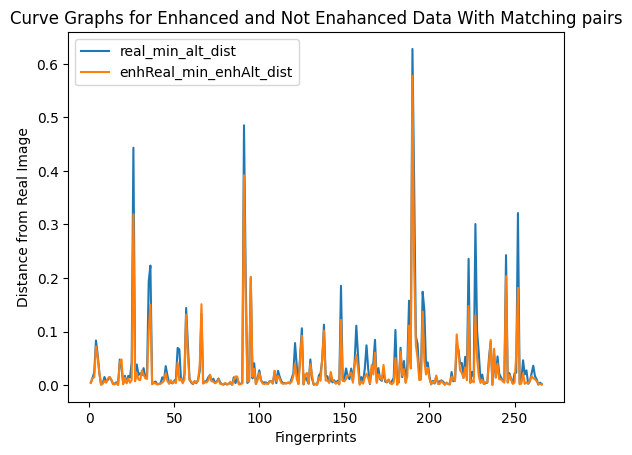

In [72]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_CR
#y2_data = real_min_enhAlt_dist[:100]
y3_data = enhReal_min_enhAlt_dist_CR

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Not Enahanced Data With Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()


In [73]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(real_min_alt_dist_CR)
for dist1,dist2 in zip(real_min_alt_dist_CR,enhReal_min_enhAlt_dist_CR):
  if dist1>dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

195
71
postive_percent for matching pairs 73.30827067669173
negative_percent for matching pairs 26.691729323308273


In [74]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(real_min_alt_dist_Obl)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

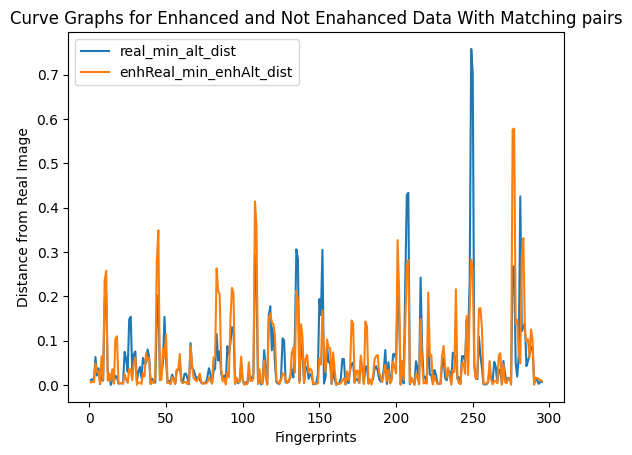

In [75]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_Obl
#y2_data = real_min_enhAlt_dist[:100]
y3_data = enhReal_min_enhAlt_dist_Obl

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Not Enahanced Data With Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [76]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(real_min_alt_dist_Obl)
for dist1,dist2 in zip(real_min_alt_dist_Obl,enhReal_min_enhAlt_dist_Obl):
  if dist1>dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

154
141
postive_percent for matching pairs 52.20338983050847
negative_percent for matching pairs 47.79661016949153


In [77]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(real_min_alt_dist_Zcut)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)


In [78]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(real_min_alt_dist_Zcut)
for dist1,dist2 in zip(real_min_alt_dist_Obl,enhReal_min_enhAlt_dist_Zcut):
  if dist1>dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

208
41
postive_percent for matching pairs 83.53413654618474
negative_percent for matching pairs 16.46586345381526


In [83]:
#code for non-matching pairs
import random
from tqdm import tqdm

prefix_to_extract = '/content/drive/MyDrive/SOCOFing/SOCOFing'

# Check if the input string contains the prefix to extract
ids = list(test_dict.keys())

# Create a tqdm instance to track progress
for id in tqdm(ids[:100]):
    input_stringList = test_dict[id]
    for input_string in input_stringList:
        if prefix_to_extract in input_string:
            # Extract the prefix part
            extracted_prefix = input_string.split(prefix_to_extract)[0] + prefix_to_extract

            # Extract the image name
            image_name = input_string.split(prefix_to_extract)[1].split('/')[-1]
            #print(image_name)
            # Remove undesired parts (e.g., "_CR.BMP")
            suffix = "_" + image_name.split('_')[-1]
            #print(suffix)
            if image_name.endswith(suffix):
                result_string = image_name.rstrip(suffix)
                result_string = result_string + '.BMP'
                #print(result_string)

            # Append the suffix to the prefix
            real_image_path = extracted_prefix + '/Real/' + result_string
            alt_image_path=input_string
            while alt_image_path==input_string:
              randomId=random.choice(ids)
              randomIdLength= len(test_dict[randomId])
              random_number = random.randint(0, randomIdLength-1)
              alt_image_path = test_dict[randomId][random_number]

            compute_distance(real_image_path, alt_image_path)

  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/107__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.5553156
Distance between real - enhanced altered:  1.5453618
Distance between enhanced real - enhanced altered:  1.5032357
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/164__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.5641106
Distance between real - enhanced altered:  1.493525
Distance between enhanced real - enhanced altered:  1.4418404
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/17__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4177624
Distance between real - enhanced altered:  1.0781631
Distance between enhanced real - enhanced altered:  1.1757591
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Alter

  1%|          | 1/100 [00:10<16:49, 10.19s/it]

Distance between real - altered:  1.223527
Distance between real - enhanced altered:  0.5734762
Distance between enhanced real - enhanced altered:  0.64528996
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/186__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.7178159
Distance between real - enhanced altered:  1.6594244
Distance between enhanced real - enhanced altered:  1.6760203
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/188__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1084274
Distance between real - enhanced altered:  1.0793113
Distance between enhanced real - enhanced altered:  1.0413055
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/171__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.7237681
Di

  2%|▏         | 2/100 [00:17<13:50,  8.48s/it]

Distance between real - altered:  1.213219
Distance between real - enhanced altered:  1.2059009
Distance between enhanced real - enhanced altered:  1.3179579
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/125__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8334196
Distance between real - enhanced altered:  0.9044921
Distance between enhanced real - enhanced altered:  0.96694016
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/173__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.7822151
Distance between real - enhanced altered:  0.7935243
Distance between enhanced real - enhanced altered:  0.86481196
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2463647
Dis

  3%|▎         | 3/100 [00:23<11:58,  7.41s/it]

Distance between real - altered:  1.5440422
Distance between real - enhanced altered:  1.5799817
Distance between enhanced real - enhanced altered:  1.5835488
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/142__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.98489416
Distance between real - enhanced altered:  1.1367834
Distance between enhanced real - enhanced altered:  1.1024562
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/130__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.046992
Distance between real - enhanced altered:  1.273755
Distance between enhanced real - enhanced altered:  1.3045411
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/109__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.37977284
Distance bet

  4%|▍         | 4/100 [00:31<12:24,  7.75s/it]

Distance between real - altered:  1.3294737
Distance between real - enhanced altered:  1.4827796
Distance between enhanced real - enhanced altered:  1.5035309
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/14__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.76719964
Distance between real - enhanced altered:  0.76275116
Distance between enhanced real - enhanced altered:  0.81083965
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/103__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2024816
Distance between real - enhanced altered:  1.2357694
Distance between enhanced real - enhanced altered:  1.2499765
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/167__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.1388425
Dist

  5%|▌         | 5/100 [00:38<11:53,  7.51s/it]

Distance between real - altered:  1.4556057
Distance between real - enhanced altered:  1.5230079
Distance between enhanced real - enhanced altered:  1.5193528
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/144__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.8768412
Distance between real - enhanced altered:  0.7654541
Distance between enhanced real - enhanced altered:  0.87128884
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/173__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.2619195
Distance between real - enhanced altered:  0.2571817
Distance between enhanced real - enhanced altered:  0.5781203
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/127__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.88089275
Dista

  6%|▌         | 6/100 [00:43<10:23,  6.64s/it]

Distance between real - altered:  1.811959
Distance between real - enhanced altered:  1.8246982
Distance between enhanced real - enhanced altered:  1.7877649
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/148__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.32804215
Distance between real - enhanced altered:  0.45959976
Distance between enhanced real - enhanced altered:  0.33503723
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/156__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.81903654
Distance between real - enhanced altered:  0.82931906
Distance between enhanced real - enhanced altered:  1.0036118
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/177__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.49887964

  7%|▋         | 7/100 [00:48<09:24,  6.07s/it]

Distance between real - altered:  1.6003547
Distance between real - enhanced altered:  1.6356249
Distance between enhanced real - enhanced altered:  1.602221
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4758327
Distance between real - enhanced altered:  1.5182496
Distance between enhanced real - enhanced altered:  1.5060465
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/159__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3962802
Distance between real - enhanced altered:  1.4102567
Distance between enhanced real - enhanced altered:  1.4352784
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/13__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.3517431
Distance between 

  8%|▊         | 8/100 [00:56<10:06,  6.59s/it]

Distance between real - altered:  1.5010237
Distance between real - enhanced altered:  1.5329019
Distance between enhanced real - enhanced altered:  1.5192441
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/164__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.92607903
Distance between real - enhanced altered:  1.1264048
Distance between enhanced real - enhanced altered:  1.1671602
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/186__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.67420745
Distance between real - enhanced altered:  0.80263144
Distance between enhanced real - enhanced altered:  0.72383434
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/148__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9926342
Distan

  9%|▉         | 9/100 [01:00<08:48,  5.81s/it]

Distance between real - altered:  0.9760193
Distance between real - enhanced altered:  1.080446
Distance between enhanced real - enhanced altered:  1.0675143
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/142__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1341882
Distance between real - enhanced altered:  1.1854064
Distance between enhanced real - enhanced altered:  0.7039874
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/113__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.13704
Distance between real - enhanced altered:  1.2565675
Distance between enhanced real - enhanced altered:  1.1866022
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/17__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.1029705
Distanc

 10%|█         | 10/100 [01:05<08:26,  5.62s/it]

Distance between real - altered:  1.6263536
Distance between real - enhanced altered:  1.6770684
Distance between enhanced real - enhanced altered:  1.5890932
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/113__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7111226
Distance between real - enhanced altered:  0.8095465
Distance between enhanced real - enhanced altered:  0.78294617
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/148__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2919455
Distance between real - enhanced altered:  1.3782634
Distance between enhanced real - enhanced altered:  1.3762205
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/134__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.8328334
Distance 

 11%|█         | 11/100 [01:11<08:31,  5.75s/it]

Distance between real - altered:  1.6753348
Distance between real - enhanced altered:  1.7226821
Distance between enhanced real - enhanced altered:  1.7153707
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/184__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4426566
Distance between real - enhanced altered:  1.4956827
Distance between enhanced real - enhanced altered:  1.452172
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4756296
Distance between real - enhanced altered:  1.5752665
Distance between enhanced real - enhanced altered:  1.6571254
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/154__F_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2271538
Distan

 12%|█▏        | 12/100 [01:16<08:03,  5.49s/it]

Distance between real - altered:  1.5647486
Distance between real - enhanced altered:  1.5827311
Distance between enhanced real - enhanced altered:  1.6205492
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/147__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2704263
Distance between real - enhanced altered:  1.4696321
Distance between enhanced real - enhanced altered:  1.5740739
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/146__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.442417
Distance between real - enhanced altered:  1.5215974
Distance between enhanced real - enhanced altered:  1.5301399
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/145__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6482607
Distance b

 13%|█▎        | 13/100 [01:22<07:52,  5.43s/it]

Distance between real - altered:  0.50343215
Distance between real - enhanced altered:  0.56226695
Distance between enhanced real - enhanced altered:  0.5100537
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/148__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6020721
Distance between real - enhanced altered:  1.6040871
Distance between enhanced real - enhanced altered:  1.6045715
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4072607
Distance between real - enhanced altered:  1.4223504
Distance between enhanced real - enhanced altered:  1.4344352
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/116__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4334099
Dista

 14%|█▍        | 14/100 [01:29<08:42,  6.08s/it]

Distance between real - altered:  1.4521532
Distance between real - enhanced altered:  1.332172
Distance between enhanced real - enhanced altered:  1.4082161
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/17__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.342054
Distance between real - enhanced altered:  1.3430991
Distance between enhanced real - enhanced altered:  1.4699129
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/127__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9409104
Distance between real - enhanced altered:  0.836892
Distance between enhanced real - enhanced altered:  0.96024925
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/101__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.711736
Distance bet

 15%|█▌        | 15/100 [01:37<09:14,  6.52s/it]

Distance between real - altered:  1.3837322
Distance between real - enhanced altered:  1.3650683
Distance between enhanced real - enhanced altered:  1.4586965
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/163__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.7863148
Distance between real - enhanced altered:  0.8523637
Distance between enhanced real - enhanced altered:  0.8129882
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/14__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.8730185
Distance between real - enhanced altered:  1.0003614
Distance between enhanced real - enhanced altered:  1.0549775
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/113__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.424312
Dista

 16%|█▌        | 16/100 [01:43<08:53,  6.35s/it]

Distance between real - altered:  1.745678
Distance between real - enhanced altered:  1.6465256
Distance between enhanced real - enhanced altered:  1.6487098
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/145__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3702159
Distance between real - enhanced altered:  1.3845819
Distance between enhanced real - enhanced altered:  1.4380839
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/187__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2516946
Distance between real - enhanced altered:  1.2780638
Distance between enhanced real - enhanced altered:  1.2832341
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/168__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1984742
Distance 

 17%|█▋        | 17/100 [01:50<09:02,  6.54s/it]

Distance between real - altered:  1.1374083
Distance between real - enhanced altered:  1.155806
Distance between enhanced real - enhanced altered:  1.2460942
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/171__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3954654
Distance between real - enhanced altered:  1.3180356
Distance between enhanced real - enhanced altered:  1.3950373
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/142__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.4518799
Distance between real - enhanced altered:  1.4364582
Distance between enhanced real - enhanced altered:  1.4595052
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/189__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5225589
Distance 

 18%|█▊        | 18/100 [01:53<07:37,  5.58s/it]

Distance between real - altered:  0.7382169
Distance between real - enhanced altered:  0.4027124
Distance between enhanced real - enhanced altered:  1.0196941
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/140__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4348413
Distance between real - enhanced altered:  1.4885842
Distance between enhanced real - enhanced altered:  1.5529156
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.5301687
Distance between real - enhanced altered:  1.6261287
Distance between enhanced real - enhanced altered:  1.5590688
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/128__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8361943
Distance 

 19%|█▉        | 19/100 [01:57<06:58,  5.17s/it]

Distance between real - altered:  0.7725611
Distance between real - enhanced altered:  0.78409266
Distance between enhanced real - enhanced altered:  0.955399
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/148__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8414722
Distance between real - enhanced altered:  1.002075
Distance between enhanced real - enhanced altered:  0.8652554
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/143__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.9934363
Distance between real - enhanced altered:  1.0691011
Distance between enhanced real - enhanced altered:  1.1038642
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/141__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.0233607
Distance be

 20%|██        | 20/100 [02:02<06:50,  5.14s/it]

Distance between real - altered:  1.1770127
Distance between real - enhanced altered:  1.2059686
Distance between enhanced real - enhanced altered:  1.2409832
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/151__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.0421817
Distance between real - enhanced altered:  1.077204
Distance between enhanced real - enhanced altered:  1.0619191
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/151__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.8021228
Distance between real - enhanced altered:  0.5661651
Distance between enhanced real - enhanced altered:  0.6387155
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/185__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.63779753
Di

 21%|██        | 21/100 [02:06<06:24,  4.86s/it]

Distance between real - altered:  1.4028393
Distance between real - enhanced altered:  1.4543898
Distance between enhanced real - enhanced altered:  1.484257
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/140__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.241548
Distance between real - enhanced altered:  1.2540005
Distance between enhanced real - enhanced altered:  1.2979753
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/135__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.40800577
Distance between real - enhanced altered:  0.49679974
Distance between enhanced real - enhanced altered:  0.45838213
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/186__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.7112051
Dis

 22%|██▏       | 22/100 [02:10<05:53,  4.54s/it]

Distance between real - altered:  0.719639
Distance between real - enhanced altered:  0.6686453
Distance between enhanced real - enhanced altered:  0.7876251
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/105__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1690863
Distance between real - enhanced altered:  1.282106
Distance between enhanced real - enhanced altered:  1.3430886
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/154__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2494496
Distance between real - enhanced altered:  1.2468861
Distance between enhanced real - enhanced altered:  1.241252
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/176__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.338943
Distance betwee

 23%|██▎       | 23/100 [02:18<07:10,  5.59s/it]

Distance between real - altered:  1.2922567
Distance between real - enhanced altered:  1.3290482
Distance between enhanced real - enhanced altered:  1.3648969
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/186__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.2665415
Distance between real - enhanced altered:  1.3285918
Distance between enhanced real - enhanced altered:  1.3182726
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/186__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.2628866
Distance between real - enhanced altered:  1.3254375
Distance between enhanced real - enhanced altered:  1.3153389
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/175__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.4791553
Distance bet

 24%|██▍       | 24/100 [02:21<05:58,  4.72s/it]

Distance between real - altered:  1.2157465
Distance between real - enhanced altered:  1.3058023
Distance between enhanced real - enhanced altered:  1.3549802
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/182__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.4580346
Distance between real - enhanced altered:  1.4855078
Distance between enhanced real - enhanced altered:  1.5464292
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/149__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3827068
Distance between real - enhanced altered:  1.4734042
Distance between enhanced real - enhanced altered:  1.4683331
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/138__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.97326654
Distance b

 25%|██▌       | 25/100 [02:29<07:00,  5.61s/it]

Distance between real - altered:  1.0428964
Distance between real - enhanced altered:  1.1514703
Distance between enhanced real - enhanced altered:  1.1913755
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/107__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5558562
Distance between real - enhanced altered:  1.5482389
Distance between enhanced real - enhanced altered:  1.5544568
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/175__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.5884815
Distance between real - enhanced altered:  1.637105
Distance between enhanced real - enhanced altered:  1.6504977
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/181__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.547793
Dis

 26%|██▌       | 26/100 [02:37<07:51,  6.37s/it]

Distance between real - altered:  1.4690298
Distance between real - enhanced altered:  1.4990735
Distance between enhanced real - enhanced altered:  1.5139356
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/164__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 27ms/step
Distance between real - altered:  1.681969
Distance between real - enhanced altered:  1.7022805
Distance between enhanced real - enhanced altered:  1.6747499
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/218__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  1.1544012
Distance between real - enhanced altered:  1.1030291
Distance between enhanced real - enhanced altered:  1.0716089
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/218__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 27ms/step
Distance between real - altered:  1.47518
Distance betwee

 27%|██▋       | 27/100 [02:42<07:19,  6.01s/it]

Distance between real - altered:  1.7629412
Distance between real - enhanced altered:  1.6910797
Distance between enhanced real - enhanced altered:  1.6752025
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/142__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 27ms/step
Distance between real - altered:  1.5702015
Distance between real - enhanced altered:  1.5964594
Distance between enhanced real - enhanced altered:  1.590613
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/12__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 28ms/step
Distance between real - altered:  1.4393506
Distance between real - enhanced altered:  1.4223422
Distance between enhanced real - enhanced altered:  1.4219279
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/152__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 30ms/step
Distance between real - altered:  1.7157997
Distance between 

 28%|██▊       | 28/100 [02:51<08:13,  6.85s/it]

Distance between real - altered:  1.6418339
Distance between real - enhanced altered:  1.6363977
Distance between enhanced real - enhanced altered:  1.6122962
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/133__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  1.2748753
Distance between real - enhanced altered:  1.3075159
Distance between enhanced real - enhanced altered:  1.2641618
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/118__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  1.253854
Distance between real - enhanced altered:  1.3090796
Distance between enhanced real - enhanced altered:  1.5019867
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/163__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.4554733
Dista

 29%|██▉       | 29/100 [02:57<07:45,  6.56s/it]

Distance between real - altered:  1.0663264
Distance between real - enhanced altered:  1.033124
Distance between enhanced real - enhanced altered:  1.3362973
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/119__F_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.1782622
Distance between real - enhanced altered:  1.2509834
Distance between enhanced real - enhanced altered:  1.3021742
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/137__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.5043737
Distance between real - enhanced altered:  0.7541128
Distance between enhanced real - enhanced altered:  0.77305484
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/144__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.0934181
Distan

 30%|███       | 30/100 [03:02<07:15,  6.22s/it]

Distance between real - altered:  1.6898698
Distance between real - enhanced altered:  1.6149383
Distance between enhanced real - enhanced altered:  1.601592
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/141__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3327595
Distance between real - enhanced altered:  1.3720995
Distance between enhanced real - enhanced altered:  1.4251931
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/159__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.6342651
Distance between real - enhanced altered:  1.7091645
Distance between enhanced real - enhanced altered:  1.7219206
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/12__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6296988
Distanc

 31%|███       | 31/100 [03:08<07:10,  6.24s/it]

Distance between real - altered:  1.1893756
Distance between real - enhanced altered:  1.2848333
Distance between enhanced real - enhanced altered:  1.2832131
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/126__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2627926
Distance between real - enhanced altered:  1.3467227
Distance between enhanced real - enhanced altered:  1.3846885
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/155__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2521086
Distance between real - enhanced altered:  1.329103
Distance between enhanced real - enhanced altered:  1.3992152
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/142__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.86176926
Dis

 32%|███▏      | 32/100 [03:16<07:23,  6.53s/it]

Distance between real - altered:  1.4945576
Distance between real - enhanced altered:  1.5685077
Distance between enhanced real - enhanced altered:  1.5996071
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.7801737
Distance between real - enhanced altered:  0.8372202
Distance between enhanced real - enhanced altered:  0.92353505
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/106__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4436665
Distance between real - enhanced altered:  1.5348295
Distance between enhanced real - enhanced altered:  1.576285
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/117__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2670927
Distan

 33%|███▎      | 33/100 [03:24<07:55,  7.09s/it]

Distance between real - altered:  1.3719428
Distance between real - enhanced altered:  1.4119427
Distance between enhanced real - enhanced altered:  1.4600405
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/126__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.6249198
Distance between real - enhanced altered:  0.79095066
Distance between enhanced real - enhanced altered:  0.75697255
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/130__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.85069114
Distance between real - enhanced altered:  0.9466244
Distance between enhanced real - enhanced altered:  0.96843386
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/105__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.84289205
Distan

 34%|███▍      | 34/100 [03:31<07:47,  7.09s/it]

Distance between real - altered:  1.5015388
Distance between real - enhanced altered:  1.5893106
Distance between enhanced real - enhanced altered:  1.5750141
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/153__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2304173
Distance between real - enhanced altered:  1.2575171
Distance between enhanced real - enhanced altered:  1.4023409
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/109__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.5110493
Distance between real - enhanced altered:  1.4605635
Distance between enhanced real - enhanced altered:  1.4937505
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/124__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.7210066
Distance be

 35%|███▌      | 35/100 [03:40<08:11,  7.56s/it]

Distance between real - altered:  0.8330946
Distance between real - enhanced altered:  0.6493419
Distance between enhanced real - enhanced altered:  0.9635603
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/17__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2647902
Distance between real - enhanced altered:  1.2389169
Distance between enhanced real - enhanced altered:  1.2014686
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/182__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4568064
Distance between real - enhanced altered:  1.5052904
Distance between enhanced real - enhanced altered:  1.5080452
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/173__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.7599014
Dista

 36%|███▌      | 36/100 [03:46<07:45,  7.28s/it]

Distance between real - altered:  1.0555533
Distance between real - enhanced altered:  0.97063816
Distance between enhanced real - enhanced altered:  1.0524917
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/160__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.6300496
Distance between real - enhanced altered:  0.83111775
Distance between enhanced real - enhanced altered:  0.6914977
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/116__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.606633
Distance between real - enhanced altered:  1.6227041
Distance between enhanced real - enhanced altered:  1.7163221
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6346673
Distanc

 37%|███▋      | 37/100 [03:52<07:01,  6.69s/it]

Distance between real - altered:  1.538771
Distance between real - enhanced altered:  1.7315693
Distance between enhanced real - enhanced altered:  1.6758118
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/177__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.71322066
Distance between real - enhanced altered:  0.8451092
Distance between enhanced real - enhanced altered:  0.9001615
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/188__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2493942
Distance between real - enhanced altered:  1.319075
Distance between enhanced real - enhanced altered:  1.3669415
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.0411391
Distance 

 38%|███▊      | 38/100 [03:59<07:13,  6.98s/it]

Distance between real - altered:  0.74883944
Distance between real - enhanced altered:  0.77533734
Distance between enhanced real - enhanced altered:  0.75414175
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/131__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0577377
Distance between real - enhanced altered:  1.0369107
Distance between enhanced real - enhanced altered:  1.0808256
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/156__F_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7552486
Distance between real - enhanced altered:  0.76721096
Distance between enhanced real - enhanced altered:  0.90068203
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2816132


 39%|███▉      | 39/100 [04:06<06:56,  6.82s/it]

Distance between real - altered:  1.228888
Distance between real - enhanced altered:  1.2993783
Distance between enhanced real - enhanced altered:  1.3728625
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/130__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.6357402
Distance between real - enhanced altered:  1.6584119
Distance between enhanced real - enhanced altered:  1.5157152
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/183__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3789712
Distance between real - enhanced altered:  1.3116789
Distance between enhanced real - enhanced altered:  1.4139528
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/111__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1997142
Distance b

 40%|████      | 40/100 [04:14<07:14,  7.25s/it]

Distance between real - altered:  1.5467864
Distance between real - enhanced altered:  1.4930675
Distance between enhanced real - enhanced altered:  1.4290098
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/123__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.689761
Distance between real - enhanced altered:  1.6460963
Distance between enhanced real - enhanced altered:  1.7138091
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.499397
Distance between real - enhanced altered:  1.6200329
Distance between enhanced real - enhanced altered:  1.7374763
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/115__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.557436
Distance betw

 41%|████      | 41/100 [04:23<07:36,  7.74s/it]

Distance between real - altered:  1.7385737
Distance between real - enhanced altered:  1.7317668
Distance between enhanced real - enhanced altered:  1.7748309
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/13__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.3775947
Distance between real - enhanced altered:  1.5245712
Distance between enhanced real - enhanced altered:  1.5532857
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/144__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9370823
Distance between real - enhanced altered:  1.0632395
Distance between enhanced real - enhanced altered:  0.86007273
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/124__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4097042
Distance 

 42%|████▏     | 42/100 [04:31<07:36,  7.87s/it]

Distance between real - altered:  0.4509466
Distance between real - enhanced altered:  0.42882323
Distance between enhanced real - enhanced altered:  0.5727007
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/130__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.492447
Distance between real - enhanced altered:  0.47414154
Distance between enhanced real - enhanced altered:  0.6127878
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/105__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3789722
Distance between real - enhanced altered:  1.4322664
Distance between enhanced real - enhanced altered:  1.4376309
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/164__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.29054868
Dis

 43%|████▎     | 43/100 [04:38<07:08,  7.51s/it]

Distance between real - altered:  0.47071323
Distance between real - enhanced altered:  0.49031803
Distance between enhanced real - enhanced altered:  0.62323356
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/104__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 17ms/step
Distance between real - altered:  1.4724511
Distance between real - enhanced altered:  1.5101231
Distance between enhanced real - enhanced altered:  1.5524169
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/111__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.91801316
Distance between real - enhanced altered:  0.86431897
Distance between enhanced real - enhanced altered:  0.98528266
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6

 44%|████▍     | 44/100 [04:44<06:38,  7.11s/it]

Distance between real - altered:  1.309977
Distance between real - enhanced altered:  1.2380228
Distance between enhanced real - enhanced altered:  1.1939098
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/117__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.042627
Distance between real - enhanced altered:  1.0561515
Distance between enhanced real - enhanced altered:  1.1040545
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.0391347
Distance between real - enhanced altered:  1.0299338
Distance between enhanced real - enhanced altered:  1.1803151
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/121__F_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.49075615
Distance

 45%|████▌     | 45/100 [04:51<06:25,  7.02s/it]

Distance between real - altered:  1.0804029
Distance between real - enhanced altered:  1.0364671
Distance between enhanced real - enhanced altered:  1.0709131
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/137__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5482743
Distance between real - enhanced altered:  1.5735836
Distance between enhanced real - enhanced altered:  1.6402193
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/105__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1220613
Distance between real - enhanced altered:  1.0661367
Distance between enhanced real - enhanced altered:  1.2730216
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/140__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.1676171
Distance b

 46%|████▌     | 46/100 [04:59<06:33,  7.28s/it]

Distance between real - altered:  1.1578776
Distance between real - enhanced altered:  0.9378537
Distance between enhanced real - enhanced altered:  0.8096204
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/109__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.71297306
Distance between real - enhanced altered:  0.9260008
Distance between enhanced real - enhanced altered:  0.8637695
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/173__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3909363
Distance between real - enhanced altered:  1.3631485
Distance between enhanced real - enhanced altered:  1.3403897
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/114__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3628736
Distance b

 47%|████▋     | 47/100 [05:05<06:11,  7.00s/it]

Distance between real - altered:  1.5690863
Distance between real - enhanced altered:  1.5935836
Distance between enhanced real - enhanced altered:  1.6463653
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/112__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.5751433
Distance between real - enhanced altered:  1.5940751
Distance between enhanced real - enhanced altered:  1.6006678
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/145__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.75085896
Distance between real - enhanced altered:  0.76800364
Distance between enhanced real - enhanced altered:  0.81033087
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/169__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3749498
Distance 

 48%|████▊     | 48/100 [05:11<05:49,  6.72s/it]

Distance between real - altered:  1.4900718
Distance between real - enhanced altered:  1.4799192
Distance between enhanced real - enhanced altered:  1.4895875
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/16__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.9678774
Distance between real - enhanced altered:  0.94451135
Distance between enhanced real - enhanced altered:  1.1406767
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/156__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0285584
Distance between real - enhanced altered:  1.020763
Distance between enhanced real - enhanced altered:  1.2162133
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/173__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.87843263
Dis

 49%|████▉     | 49/100 [05:20<06:15,  7.36s/it]

Distance between real - altered:  1.3846332
Distance between real - enhanced altered:  1.4076362
Distance between enhanced real - enhanced altered:  1.5582167
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/153__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.0236211
Distance between real - enhanced altered:  1.0166792
Distance between enhanced real - enhanced altered:  1.2781425
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/180__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5779274
Distance between real - enhanced altered:  1.6371431
Distance between enhanced real - enhanced altered:  1.5797118
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0373683
Distance be

 50%|█████     | 50/100 [05:28<06:19,  7.58s/it]

Distance between real - altered:  1.0965111
Distance between real - enhanced altered:  1.201365
Distance between enhanced real - enhanced altered:  1.1375003
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/115__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1711814
Distance between real - enhanced altered:  1.205584
Distance between enhanced real - enhanced altered:  1.2340473
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/123__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.4044592
Distance between real - enhanced altered:  1.4840398
Distance between enhanced real - enhanced altered:  1.520863
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/137__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9868761
Distance betwee

 51%|█████     | 51/100 [05:34<05:46,  7.07s/it]

Distance between real - altered:  0.72149
Distance between real - enhanced altered:  0.862268
Distance between enhanced real - enhanced altered:  0.905354
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/131__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4399949
Distance between real - enhanced altered:  1.4803165
Distance between enhanced real - enhanced altered:  1.5114458
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/139__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5370939
Distance between real - enhanced altered:  1.5796427
Distance between enhanced real - enhanced altered:  1.59693
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/112__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.0326409
Distance between

 52%|█████▏    | 52/100 [05:41<05:41,  7.12s/it]

Distance between real - altered:  0.9938188
Distance between real - enhanced altered:  0.96490604
Distance between enhanced real - enhanced altered:  1.0971757
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/172__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.6579425
Distance between real - enhanced altered:  1.6622415
Distance between enhanced real - enhanced altered:  1.7038805
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/113__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2680885
Distance between real - enhanced altered:  1.4099488
Distance between enhanced real - enhanced altered:  1.4195964
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/163__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.65443677
D

 53%|█████▎    | 53/100 [05:48<05:27,  6.97s/it]

Distance between real - altered:  1.2860378
Distance between real - enhanced altered:  1.3475472
Distance between enhanced real - enhanced altered:  1.3280231
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/188__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.6815016
Distance between real - enhanced altered:  1.683678
Distance between enhanced real - enhanced altered:  1.6918383
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/185__M_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5357438
Distance between real - enhanced altered:  1.5273949
Distance between enhanced real - enhanced altered:  1.4336543
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/155__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5873135
Distan

 54%|█████▍    | 54/100 [05:56<05:33,  7.24s/it]

Distance between real - altered:  1.6138552
Distance between real - enhanced altered:  1.6277162
Distance between enhanced real - enhanced altered:  1.695899
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/118__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6372807
Distance between real - enhanced altered:  1.61316
Distance between enhanced real - enhanced altered:  1.5420746
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/185__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.9987755
Distance between real - enhanced altered:  1.0082167
Distance between enhanced real - enhanced altered:  0.6010164
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/135__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.472844
Distance be

 55%|█████▌    | 55/100 [06:02<05:12,  6.95s/it]

Distance between real - altered:  0.9051699
Distance between real - enhanced altered:  0.59282494
Distance between enhanced real - enhanced altered:  1.1717061
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/134__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4328436
Distance between real - enhanced altered:  1.52678
Distance between enhanced real - enhanced altered:  1.5173888
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/18__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.633769
Distance between real - enhanced altered:  1.6703235
Distance between enhanced real - enhanced altered:  1.7050065
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/13__F_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.1214074
Distance be

 56%|█████▌    | 56/100 [06:09<05:06,  6.97s/it]

Distance between real - altered:  0.6713222
Distance between real - enhanced altered:  0.81296253
Distance between enhanced real - enhanced altered:  0.78571796
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/15__F_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.6342624
Distance between real - enhanced altered:  1.6619982
Distance between enhanced real - enhanced altered:  1.7149858
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.5549246
Distance between real - enhanced altered:  1.617068
Distance between enhanced real - enhanced altered:  1.6408931
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/188__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.4062694
Distan

 57%|█████▋    | 57/100 [06:16<05:04,  7.07s/it]

Distance between real - altered:  1.3041219
Distance between real - enhanced altered:  1.1693428
Distance between enhanced real - enhanced altered:  1.4344304
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/100__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3905743
Distance between real - enhanced altered:  1.3024832
Distance between enhanced real - enhanced altered:  1.2372493
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/150__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8407335
Distance between real - enhanced altered:  0.88758427
Distance between enhanced real - enhanced altered:  0.81253755
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/163__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0000124
Distance 

 58%|█████▊    | 58/100 [06:24<05:12,  7.44s/it]

Distance between real - altered:  0.68813914
Distance between real - enhanced altered:  0.86758983
Distance between enhanced real - enhanced altered:  0.7173326
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/117__F_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.7180809
Distance between real - enhanced altered:  1.7132243
Distance between enhanced real - enhanced altered:  1.5792428
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/144__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0347246
Distance between real - enhanced altered:  1.0645815
Distance between enhanced real - enhanced altered:  0.9718864
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/115__F_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.6457636
Distanc

 59%|█████▉    | 59/100 [06:32<05:11,  7.59s/it]

Distance between real - altered:  1.0519052
Distance between real - enhanced altered:  1.2027476
Distance between enhanced real - enhanced altered:  0.91790414
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/152__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.260522
Distance between real - enhanced altered:  1.3857931
Distance between enhanced real - enhanced altered:  1.3311896
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.5236152
Distance between real - enhanced altered:  0.6451331
Distance between enhanced real - enhanced altered:  0.6053774
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/17__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  0.65969205
Distance

 60%|██████    | 60/100 [06:37<04:29,  6.73s/it]

Distance between real - altered:  0.45770708
Distance between real - enhanced altered:  0.49066398
Distance between enhanced real - enhanced altered:  0.55487245
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/108__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7264088
Distance between real - enhanced altered:  0.73597276
Distance between enhanced real - enhanced altered:  0.86289996
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/113__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.62384087
Distance between real - enhanced altered:  0.7498053
Distance between enhanced real - enhanced altered:  0.51549697
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/102__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.85710484
Di

 61%|██████    | 61/100 [06:45<04:33,  7.01s/it]

Distance between real - altered:  1.689636
Distance between real - enhanced altered:  1.6831824
Distance between enhanced real - enhanced altered:  1.6787918
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/145__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2694824
Distance between real - enhanced altered:  1.3786689
Distance between enhanced real - enhanced altered:  1.3438951
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/102__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.55338216
Distance between real - enhanced altered:  0.5861894
Distance between enhanced real - enhanced altered:  0.6620379
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/166__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.372748
Dista

 62%|██████▏   | 62/100 [06:52<04:24,  6.97s/it]

Distance between real - altered:  0.8033227
Distance between real - enhanced altered:  0.86762923
Distance between enhanced real - enhanced altered:  0.98326206
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/155__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3857696
Distance between real - enhanced altered:  1.4792752
Distance between enhanced real - enhanced altered:  1.4894062
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/106__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.5766312
Distance between real - enhanced altered:  0.51212025
Distance between enhanced real - enhanced altered:  0.55586475
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/171__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.8319184
Distan

 63%|██████▎   | 63/100 [06:55<03:42,  6.00s/it]

Distance between real - altered:  1.765337
Distance between real - enhanced altered:  1.6972346
Distance between enhanced real - enhanced altered:  1.6933755
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/134__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7648664
Distance between real - enhanced altered:  1.1361991
Distance between enhanced real - enhanced altered:  1.1715136
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/182__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4059304
Distance between real - enhanced altered:  1.4295839
Distance between enhanced real - enhanced altered:  1.4516369
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/126__F_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4737986
Distance b

 64%|██████▍   | 64/100 [07:03<03:49,  6.37s/it]

Distance between real - altered:  1.2342832
Distance between real - enhanced altered:  1.4299153
Distance between enhanced real - enhanced altered:  1.4903351
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/16__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.36278844
Distance between real - enhanced altered:  0.5444966
Distance between enhanced real - enhanced altered:  0.46939135
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.67083883
Distance between real - enhanced altered:  0.93968296
Distance between enhanced real - enhanced altered:  0.8177747
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/155__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.6228608
Distan

 65%|██████▌   | 65/100 [07:10<03:56,  6.75s/it]

Distance between real - altered:  0.9911764
Distance between real - enhanced altered:  1.3521048
Distance between enhanced real - enhanced altered:  1.3270944
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/180__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5910774
Distance between real - enhanced altered:  1.6273794
Distance between enhanced real - enhanced altered:  1.6504518
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.4296236
Distance between real - enhanced altered:  1.4074407
Distance between enhanced real - enhanced altered:  1.4165158
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/124__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.44044
Distanc

 66%|██████▌   | 66/100 [07:18<03:56,  6.97s/it]

Distance between real - altered:  1.2358707
Distance between real - enhanced altered:  1.2829194
Distance between enhanced real - enhanced altered:  1.3380548
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/174__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.249716
Distance between real - enhanced altered:  1.3219811
Distance between enhanced real - enhanced altered:  1.3370692
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/112__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2695405
Distance between real - enhanced altered:  1.322111
Distance between enhanced real - enhanced altered:  1.3416666
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/162__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.61336446
Distan

 67%|██████▋   | 67/100 [07:25<03:50,  6.97s/it]

Distance between real - altered:  1.455894
Distance between real - enhanced altered:  1.4571203
Distance between enhanced real - enhanced altered:  1.4692707
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/117__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.1262807
Distance between real - enhanced altered:  1.2119559
Distance between enhanced real - enhanced altered:  1.2402362
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/117__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3331634
Distance between real - enhanced altered:  1.4613482
Distance between enhanced real - enhanced altered:  1.476888
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/136__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3045416
Distance 

 68%|██████▊   | 68/100 [07:31<03:37,  6.78s/it]

Distance between real - altered:  0.91354084
Distance between real - enhanced altered:  1.1642205
Distance between enhanced real - enhanced altered:  1.1347677
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/143__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6375827
Distance between real - enhanced altered:  1.5685942
Distance between enhanced real - enhanced altered:  1.6073155
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/173__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3049232
Distance between real - enhanced altered:  1.1852114
Distance between enhanced real - enhanced altered:  1.324986
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/154__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.7681173
Dista

 69%|██████▉   | 69/100 [07:37<03:25,  6.64s/it]

Distance between real - altered:  0.5975327
Distance between real - enhanced altered:  0.6207694
Distance between enhanced real - enhanced altered:  0.58809364
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/166__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.28694245
Distance between real - enhanced altered:  0.33242473
Distance between enhanced real - enhanced altered:  0.26411042
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/130__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.5388718
Distance between real - enhanced altered:  0.67049795
Distance between enhanced real - enhanced altered:  0.72822255
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/142__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.392871

 70%|███████   | 70/100 [07:42<03:04,  6.14s/it]

Distance between real - altered:  0.72132796
Distance between real - enhanced altered:  0.8280014
Distance between enhanced real - enhanced altered:  0.8932506
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/160__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.5810439
Distance between real - enhanced altered:  0.6810036
Distance between enhanced real - enhanced altered:  0.5527231
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/218__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.74285436
Distance between real - enhanced altered:  0.7671555
Distance between enhanced real - enhanced altered:  0.8859466
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/167__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.8292856


 71%|███████   | 71/100 [07:47<02:41,  5.57s/it]

Distance between real - altered:  1.0313854
Distance between real - enhanced altered:  1.0983607
Distance between enhanced real - enhanced altered:  1.1510252
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/133__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.99308306
Distance between real - enhanced altered:  1.1009929
Distance between enhanced real - enhanced altered:  1.1571156
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/173__F_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0320638
Distance between real - enhanced altered:  1.1434518
Distance between enhanced real - enhanced altered:  1.1687214
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/153__M_Right_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4996586
Distanc

 72%|███████▏  | 72/100 [07:53<02:44,  5.87s/it]

Distance between real - altered:  0.75670403
Distance between real - enhanced altered:  0.8594619
Distance between enhanced real - enhanced altered:  0.7897364
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/186__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.1741114
Distance between real - enhanced altered:  1.2906916
Distance between enhanced real - enhanced altered:  1.3315916
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/177__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1407765
Distance between real - enhanced altered:  1.248938
Distance between enhanced real - enhanced altered:  1.265568
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/182__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.0264088
Dis

 73%|███████▎  | 73/100 [07:59<02:39,  5.89s/it]

Distance between real - altered:  1.5363327
Distance between real - enhanced altered:  1.6414152
Distance between enhanced real - enhanced altered:  1.6596773
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/115__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.8289108
Distance between real - enhanced altered:  1.1090204
Distance between enhanced real - enhanced altered:  1.1071106
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/12__M_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.4544847
Distance between real - enhanced altered:  1.5012711
Distance between enhanced real - enhanced altered:  1.4958909
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/161__F_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4878645


 74%|███████▍  | 74/100 [08:06<02:43,  6.30s/it]

Distance between real - altered:  1.5919133
Distance between real - enhanced altered:  1.6191599
Distance between enhanced real - enhanced altered:  1.6069593
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/173__F_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3455662
Distance between real - enhanced altered:  1.4184821
Distance between enhanced real - enhanced altered:  1.4363737
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/133__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.9080955
Distance between real - enhanced altered:  0.9655386
Distance between enhanced real - enhanced altered:  0.9776021
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/17__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.7741417
Distance betwee

 75%|███████▌  | 75/100 [08:13<02:41,  6.45s/it]

Distance between real - altered:  1.6229597
Distance between real - enhanced altered:  1.6973033
Distance between enhanced real - enhanced altered:  1.7133439
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/13__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.8826362
Distance between real - enhanced altered:  0.7548452
Distance between enhanced real - enhanced altered:  0.8760379
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/173__F_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3366803
Distance between real - enhanced altered:  1.206519
Distance between enhanced real - enhanced altered:  1.2954911
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/114__F_Right_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2123175
Dist

 76%|███████▌  | 76/100 [08:19<02:31,  6.30s/it]

Distance between real - altered:  1.3728658
Distance between real - enhanced altered:  1.2233584
Distance between enhanced real - enhanced altered:  1.3085746
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/136__F_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3488616
Distance between real - enhanced altered:  1.3604258
Distance between enhanced real - enhanced altered:  1.3381327
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/133__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5101266
Distance between real - enhanced altered:  1.4697137
Distance between enhanced real - enhanced altered:  1.462804
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/177__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3354305
Distance be

 77%|███████▋  | 77/100 [08:29<02:47,  7.29s/it]

Distance between real - altered:  1.6636126
Distance between real - enhanced altered:  1.685385
Distance between enhanced real - enhanced altered:  1.7082673
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/170__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.4451048
Distance between real - enhanced altered:  1.4108403
Distance between enhanced real - enhanced altered:  1.3835918
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/163__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.5400591
Distance between real - enhanced altered:  1.5179181
Distance between enhanced real - enhanced altered:  1.5939628
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/106__M_Right_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4516144
Distance bet

 78%|███████▊  | 78/100 [08:35<02:35,  7.07s/it]

Distance between real - altered:  1.3350846
Distance between real - enhanced altered:  1.3049891
Distance between enhanced real - enhanced altered:  1.2679069
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/168__M_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.3153436
Distance between real - enhanced altered:  1.3034037
Distance between enhanced real - enhanced altered:  1.3191485
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/187__M_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.4256202
Distance between real - enhanced altered:  1.4831195
Distance between enhanced real - enhanced altered:  1.5358179
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/176__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.2071457
Distance 

 79%|███████▉  | 79/100 [08:43<02:29,  7.13s/it]

Distance between real - altered:  0.94254476
Distance between real - enhanced altered:  1.042534
Distance between enhanced real - enhanced altered:  1.089945
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/144__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.40675965
Distance between real - enhanced altered:  0.49460366
Distance between enhanced real - enhanced altered:  0.43084243
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/116__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.9117662
Distance between real - enhanced altered:  0.9958431
Distance between enhanced real - enhanced altered:  1.029312
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/178__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.5608875
Distance be

 80%|████████  | 80/100 [08:50<02:21,  7.08s/it]

Distance between real - altered:  1.1829567
Distance between real - enhanced altered:  1.3297739
Distance between enhanced real - enhanced altered:  1.3422508
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/142__F_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.1090022
Distance between real - enhanced altered:  1.15664
Distance between enhanced real - enhanced altered:  1.1275717
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/182__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.215272
Distance between real - enhanced altered:  1.304134
Distance between enhanced real - enhanced altered:  1.3164388
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/186__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.0915877
Distance

 81%|████████  | 81/100 [08:55<02:06,  6.64s/it]

Distance between real - altered:  0.478093
Distance between real - enhanced altered:  0.5024699
Distance between enhanced real - enhanced altered:  0.54121435
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.1260331
Distance between real - enhanced altered:  1.3933349
Distance between enhanced real - enhanced altered:  1.3087074
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/179__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.9698329
Distance between real - enhanced altered:  1.0331683
Distance between enhanced real - enhanced altered:  1.0316812
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/150__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.6801478
Dista

 82%|████████▏ | 82/100 [09:01<01:54,  6.34s/it]

Distance between real - altered:  0.47792614
Distance between real - enhanced altered:  0.50681746
Distance between enhanced real - enhanced altered:  0.4608576
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/119__F_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.91141444
Distance between real - enhanced altered:  0.885964
Distance between enhanced real - enhanced altered:  0.8990285
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/102__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.9492308
Distance between real - enhanced altered:  0.95610774
Distance between enhanced real - enhanced altered:  1.0121698
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/12__M_Right_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9581978
Di

 83%|████████▎ | 83/100 [09:04<01:32,  5.45s/it]

Distance between real - altered:  1.4154198
Distance between real - enhanced altered:  1.502444
Distance between enhanced real - enhanced altered:  1.5231496
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/133__M_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.4874314
Distance between real - enhanced altered:  1.427232
Distance between enhanced real - enhanced altered:  1.5003006
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/129__M_Right_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.65434
Distance between real - enhanced altered:  1.6365063
Distance between enhanced real - enhanced altered:  1.5436349
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/135__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.782465
Distance bet

 84%|████████▍ | 84/100 [09:07<01:15,  4.71s/it]

Distance between real - altered:  1.7534115
Distance between real - enhanced altered:  1.7281517
Distance between enhanced real - enhanced altered:  1.6576921
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/162__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.5194507
Distance between real - enhanced altered:  1.4424541
Distance between enhanced real - enhanced altered:  1.5627156
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/180__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3612866
Distance between real - enhanced altered:  1.3377157
Distance between enhanced real - enhanced altered:  1.4786171
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/111__M_Right_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.400386
Distance

 85%|████████▌ | 85/100 [09:13<01:17,  5.15s/it]

Distance between real - altered:  1.4995054
Distance between real - enhanced altered:  1.473743
Distance between enhanced real - enhanced altered:  1.5690961
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/129__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.1305073
Distance between real - enhanced altered:  1.2797555
Distance between enhanced real - enhanced altered:  1.2884783
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/135__F_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.60012585
Distance between real - enhanced altered:  0.6843565
Distance between enhanced real - enhanced altered:  0.6863143
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/172__M_Right_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6085091
Distan

 86%|████████▌ | 86/100 [09:20<01:19,  5.66s/it]

Distance between real - altered:  0.79548997
Distance between real - enhanced altered:  0.9436259
Distance between enhanced real - enhanced altered:  0.99477595
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/103__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1371162
Distance between real - enhanced altered:  1.406235
Distance between enhanced real - enhanced altered:  1.4133697
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/122__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.067372
Distance between real - enhanced altered:  1.0832223
Distance between enhanced real - enhanced altered:  1.1971431
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/186__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.5951537
Distance b

 87%|████████▋ | 87/100 [09:27<01:18,  6.00s/it]

Distance between real - altered:  1.283989
Distance between real - enhanced altered:  1.3884418
Distance between enhanced real - enhanced altered:  1.4606142
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/119__F_Right_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.5080929
Distance between real - enhanced altered:  0.50774676
Distance between enhanced real - enhanced altered:  0.5357603
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/164__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.4047348
Distance between real - enhanced altered:  1.5239848
Distance between enhanced real - enhanced altered:  1.5528194
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/184__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.50174
Di

 88%|████████▊ | 88/100 [09:33<01:12,  6.01s/it]

Distance between real - altered:  0.66924274
Distance between real - enhanced altered:  0.86311615
Distance between enhanced real - enhanced altered:  0.82109666
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/11__M_Right_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6176376
Distance between real - enhanced altered:  1.7350295
Distance between enhanced real - enhanced altered:  1.7316724
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/162__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1136923
Distance between real - enhanced altered:  1.2388686
Distance between enhanced real - enhanced altered:  1.2632744
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/181__M_Left_thumb_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.1904279
Distance b

 89%|████████▉ | 89/100 [09:40<01:10,  6.40s/it]

Distance between real - altered:  1.6211967
Distance between real - enhanced altered:  1.683175
Distance between enhanced real - enhanced altered:  1.6604695
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/218__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 26ms/step
Distance between real - altered:  1.2040035
Distance between real - enhanced altered:  1.0824506
Distance between enhanced real - enhanced altered:  1.0044441
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/146__M_Left_ring_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  1.5640202
Distance between real - enhanced altered:  1.5857371
Distance between enhanced real - enhanced altered:  1.5107785
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/110__F_Left_thumb_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  1.465617
Distance

 90%|█████████ | 90/100 [09:43<00:52,  5.26s/it]

Distance between real - altered:  1.5519631
Distance between real - enhanced altered:  1.591229
Distance between enhanced real - enhanced altered:  1.5474259
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/146__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 27ms/step
Distance between real - altered:  1.554636
Distance between real - enhanced altered:  1.6287675
Distance between enhanced real - enhanced altered:  1.6529086
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/103__F_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 26ms/step
Distance between real - altered:  1.5087913
Distance between real - enhanced altered:  1.553597
Distance between enhanced real - enhanced altered:  1.5754123
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/176__M_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 25ms/step
Distance between real - altered:  0.9914075
Distanc

 91%|█████████ | 91/100 [09:49<00:49,  5.52s/it]

Distance between real - altered:  1.647743
Distance between real - enhanced altered:  1.6714057
Distance between enhanced real - enhanced altered:  1.6987624
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/102__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  1.16225
Distance between real - enhanced altered:  1.2865027
Distance between enhanced real - enhanced altered:  1.2425816
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/126__F_Left_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 24ms/step
Distance between real - altered:  0.24488008
Distance between real - enhanced altered:  0.29281327
Distance between enhanced real - enhanced altered:  0.30024084
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/10__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  1.2235384
Distance b

 92%|█████████▏| 92/100 [09:55<00:45,  5.72s/it]

Distance between real - altered:  1.3264931
Distance between real - enhanced altered:  1.3718284
Distance between enhanced real - enhanced altered:  1.4052691
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Right_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.7577216
Distance between real - enhanced altered:  0.83263546
Distance between enhanced real - enhanced altered:  0.8062631
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/152__M_Left_index_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.6483867
Distance between real - enhanced altered:  0.8350398
Distance between enhanced real - enhanced altered:  0.74070686
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/125__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 21ms/step
Distance between real - altered:  0.6650436
Distance b

 93%|█████████▎| 93/100 [10:02<00:42,  6.09s/it]

Distance between real - altered:  0.46588314
Distance between real - enhanced altered:  0.4845387
Distance between enhanced real - enhanced altered:  0.5105451
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/132__M_Left_middle_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.5236273
Distance between real - enhanced altered:  0.5549619
Distance between enhanced real - enhanced altered:  0.68314207
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/179__M_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.94327056
Distance between real - enhanced altered:  0.9997001
Distance between enhanced real - enhanced altered:  1.0612855
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/112__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 23ms/step
Distance between real - altered:  1.080064


 94%|█████████▍| 94/100 [10:09<00:38,  6.37s/it]

Distance between real - altered:  1.1856606
Distance between real - enhanced altered:  1.1947665
Distance between enhanced real - enhanced altered:  1.1195694
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/171__M_Left_middle_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.3055531
Distance between real - enhanced altered:  1.3311528
Distance between enhanced real - enhanced altered:  1.4315635
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/100__M_Right_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2368919
Distance between real - enhanced altered:  1.4256401
Distance between enhanced real - enhanced altered:  1.3975337
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/145__M_Left_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.67954445

 95%|█████████▌| 95/100 [10:14<00:29,  5.93s/it]

Distance between real - altered:  1.0337665
Distance between real - enhanced altered:  1.0186597
Distance between enhanced real - enhanced altered:  1.1952192
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/127__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.9704555
Distance between real - enhanced altered:  0.9383889
Distance between enhanced real - enhanced altered:  1.202407
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/144__M_Left_thumb_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.90105027
Distance between real - enhanced altered:  0.89508444
Distance between enhanced real - enhanced altered:  0.914786
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/168__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.2998813
Distanc

 96%|█████████▌| 96/100 [10:22<00:25,  6.48s/it]

Distance between real - altered:  0.711902
Distance between real - enhanced altered:  0.6906605
Distance between enhanced real - enhanced altered:  0.78406507
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/167__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.5537149
Distance between real - enhanced altered:  0.556991
Distance between enhanced real - enhanced altered:  0.6689132
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/127__F_Left_ring_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  0.81802213
Distance between real - enhanced altered:  0.8106829
Distance between enhanced real - enhanced altered:  0.90367216
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/12__M_Left_little_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.2801682
Distance b

 97%|█████████▋| 97/100 [10:26<00:17,  5.72s/it]

Distance between real - altered:  1.302431
Distance between real - enhanced altered:  1.3806882
Distance between enhanced real - enhanced altered:  1.4150033
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/112__M_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.3486136
Distance between real - enhanced altered:  1.4339603
Distance between enhanced real - enhanced altered:  1.5309741
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/13__F_Right_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  1.0494862
Distance between real - enhanced altered:  1.0245365
Distance between enhanced real - enhanced altered:  1.1844882
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/109__F_Left_index_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  0.86126137
Distance

 98%|█████████▊| 98/100 [10:30<00:10,  5.35s/it]

Distance between real - altered:  0.9272859
Distance between real - enhanced altered:  0.93481505
Distance between enhanced real - enhanced altered:  1.1377182
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/154__F_Right_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.5278305
Distance between real - enhanced altered:  1.6116289
Distance between enhanced real - enhanced altered:  1.6893573
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Easy/128__M_Left_ring_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.344891
Distance between real - enhanced altered:  1.3353635
Distance between enhanced real - enhanced altered:  1.4963329
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/116__M_Right_middle_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 19ms/step
Distance between real - altered:  1.6359227
Distance b

 99%|█████████▉| 99/100 [10:37<00:05,  5.69s/it]

Distance between real - altered:  1.0621587
Distance between real - enhanced altered:  1.0216852
Distance between enhanced real - enhanced altered:  1.212606
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/162__M_Left_little_finger_Zcut.BMP
flag Zcut
1/1 [==============================] - 0s 18ms/step
Distance between real - altered:  1.0847613
Distance between real - enhanced altered:  1.1212088
Distance between enhanced real - enhanced altered:  1.1553833
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Medium/164__M_Left_little_finger_CR.BMP
flag CR
1/1 [==============================] - 0s 20ms/step
Distance between real - altered:  0.8679647
Distance between real - enhanced altered:  0.9595878
Distance between enhanced real - enhanced altered:  1.0016179
/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/158__M_Right_index_finger_Obl.BMP
flag Obl
1/1 [==============================] - 0s 22ms/step
Distance between real - altered:  1.0902143
Dista

100%|██████████| 100/100 [10:42<00:00,  6.43s/it]

Distance between real - altered:  0.8156851
Distance between real - enhanced altered:  0.8433772
Distance between enhanced real - enhanced altered:  0.8325205


In [43]:
print(len(real_min_alt_dist))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))

810
810
810


In [84]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist_CR)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

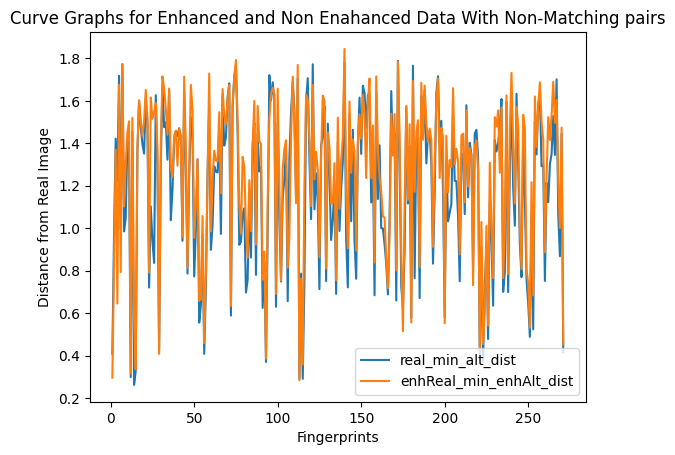

In [85]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist_CR
#y2_data = real_min_enhAlt_dist
y3_data = enhReal_min_enhAlt_dist_CR

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Non Enahanced Data With Non-Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [86]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist_CR)
for dist1,dist2 in zip(real_min_alt_dist_CR,enhReal_min_enhAlt_dist_CR):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

208
63
postive_percent for non-matching pairs 76.75276752767527
negative_percent for non-matching pairs 23.247232472324722


In [87]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist_Obl)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

In [88]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist_Obl)
for dist1,dist2 in zip(real_min_alt_dist_Obl,enhReal_min_enhAlt_dist_Obl):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

220
73
postive_percent for non-matching pairs 75.0853242320819
negative_percent for non-matching pairs 24.914675767918087


In [89]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist_Zcut)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

In [90]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist_Zcut)
for dist1,dist2 in zip(real_min_alt_dist_Zcut,enhReal_min_enhAlt_dist_Zcut):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

195
51
postive_percent for non-matching pairs 79.26829268292683
negative_percent for non-matching pairs 20.73170731707317


In [46]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

In [47]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist)
for dist1,dist2 in zip(real_min_alt_dist,enhReal_min_enhAlt_dist):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

394
416
postive_percent for non-matching pairs 48.641975308641975
negative_percent for non-matching pairs 51.358024691358025


In [91]:
TP=195
FP=71
TN=208
FN=63

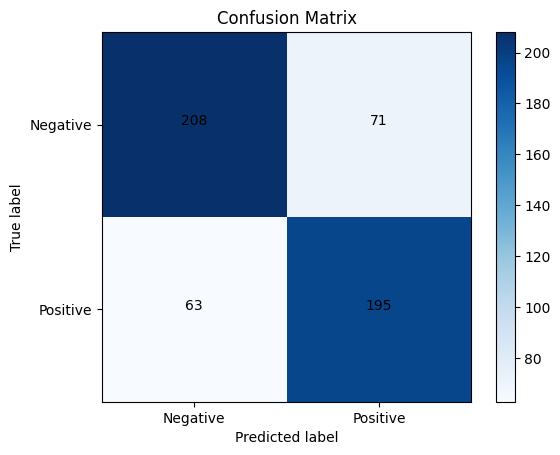

In [92]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [93]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [95]:
print("Accuracy: CR", accuracy*100)

Accuracy: CR 75.04655493482309


In [96]:
TP=154
FP=141
TN=220
FN=73

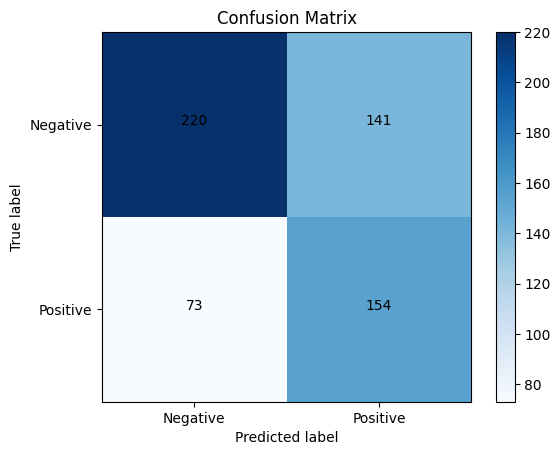

In [97]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [98]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [99]:
print("Accuracy: Obl", accuracy*100)

Accuracy: Obl 63.60544217687075


In [100]:
TP=208
FP=41
TN=195
FN=51

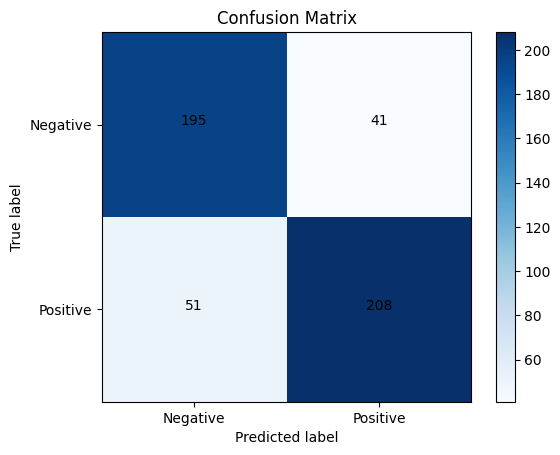

In [101]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [102]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [103]:
print("Accuracy: Zcut", accuracy*100)

Accuracy: Zcut 81.41414141414141
